**Challenge description**

"BBVA Global" recently launched a new product that has been tested on a small subset of clients (It was tested in one of the various geographies where BBVA is present). The product exceeded all expectations in terms of subscriptions, and BBVA plans to increase the portfolio of potential customers who can gain access to it. With the demographic and financial information of those who have signed up to the service, our business partners have identified several analyses that may be of interest. All are related to the profiling of clients who comply with the contractual conditions (It is important to select those customers that meet certain requirements, in order to reduce returns, complaints or claims that may entail additional costs.). Following an initial planning session with our business partners, the collected data was selected and divided into 2 datasets:

  - Customer-level data (clients.csv): the most recent demographic and financial data of the selected customers. This includes risk scores, debt, contracted product category and payable amount (in the selected currency). This dataset contains 45 variables for a base of approximately 163K clients.

  - Behavioural data (behavioural.csv): data with temporal depth at customer level with information of monthly credit card consumption. This dataset has 14 variables.

  ---

  Through the notebook I will focus on what I see most important, while giving notes of what other steps should be done or at least worth testing. I will mention papers, references and pages I would read before making a strong opinion about anything. I will also stay within the main data science Python frameworks, and offer links to others I know about.

In [2]:
%%capture

"""
Requirements
- Python 3.11
- numpy==1.26.3
- pandas==2.2.0
- seaborn==0.13.2
- scikit-learn==1.4.2
"""

# !pip install numpy, pandas, seaborn, scikit-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 12345  # For reproducibility

# Functions

Some functions I will repeatedly call during the notebook

In [2]:
# Adapted from: https://www.kaggle.com/code/oldwine357/removing-highly-correlated-features#Removing-Highly-Correlated-Columns
def remove_collinear_features(x, threshold):
    """
    Remove collinear features in a dataframe with a correlation coefficient
    greater than the threshold. Removing collinear features can help a model
    to generalize and improves the interpretability of the model.

    Args:
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output:
        dataframe that contains only the non-highly-collinear features
    """

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i + 1):
            item = corr_matrix.iloc[j : (j + 1), (i + 1) : (i + 2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    return set(drop_cols)

In [3]:
from sklearn.metrics import classification_report
from numpy.typing import NDArray

def get_classification_report(y: NDArray, y_pred: NDArray, target_names: list):
    """
    Prints the classification report and displays a heatmap of the report.

    Args:
        y (numpy.ndarray): The true labels.
        y_pred (numpy.ndarray): The predicted labels.
        target_names (list): The names of the classes.
    """
    # Print the classification report
    print(classification_report(y, y_pred, target_names=target_names))

    # From: https://stackoverflow.com/a/58948133
    # Generate the classification report as a dictionary
    clf_report = classification_report(
        y, y_pred, target_names=target_names, output_dict=True
    )

    # Create a heatmap using seaborn and display it
    sns.heatmap(
        pd.DataFrame(clf_report).iloc[:-1, :].T,
        annot=True,
        cmap="Blues",
        vmin=0.0,
        vmax=1.0,
    )
    plt.show()

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

def auc_curve(y_true, y_score):
    """
    Plot the ROC curve of a model

    Args
        model (object): Sklearn model with a predict method
    """
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--") # 0.5 baseline
    plt.title(f"AUC: {roc_auc}")
    plt.show()

In [5]:
from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall(y, y_pred, label: int = 1):
    display = PrecisionRecallDisplay.from_predictions(
        y, y_pred, name="GB", plot_chance_level=True, pos_label=label
    )
    _ = display.ax_.set_title(f"Precision-Recall curve for class {label}")

In [6]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, target_names):
    """
    Plot the confusion matrix of a model

    Args
        y_true (numpy.ndarray): The true labels.
        y_pred (numpy.ndarray): The predicted labels.
        target_names (list): The names of the classes.
    """

    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, None]

    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        vmin=0.0,
        vmax=1.0,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Load data

In [7]:
PATH_BEHAVIOURAL = "./BEHAVIOURAL.csv"
PATH_CLIENTS = "./CLIENTS.csv"

# PATH_BEHAVIOURAL = "/content/drive/MyDrive/Colab Notebooks/ChallengeBBVA/BEHAVIOURAL.csv"
# PATH_CLIENTS = "/content/drive/MyDrive/Colab Notebooks/ChallengeBBVA/CLIENTS.csv"

In [8]:
df_behavioural = pd.read_csv(PATH_BEHAVIOURAL, header=0)
df_behavioural.head()

,CONTRACT_ID,CLIENT_ID,DATE,CREDICT_CARD_BALANCE,CREDIT_CARD_LIMIT,CREDIT_CARD_DRAWINGS_ATM,CREDIT_CARD_DRAWINGS,CREDIT_CARD_DRAWINGS_POS,CREDIT_CARD_DRAWINGS_OTHER,CREDIT_CARD_PAYMENT,NUMBER_DRAWINGS_ATM,NUMBER_DRAWINGS,NUMBER_INSTALMENTS,CURRENCY
0,ES1821000018d00XXX,ES182394447V,2021-08-29,491.21,540.0,0.0,28.03,28.03,0.0,46.81,0.0,2,1.0,euros
1,ES1821000018d00XXX,ES182394447V,2021-07-29,466.55,540.0,162.0,612.51,450.51,0.0,108.00,3.0,15,0.0,euros
2,ES1821000018d00XXX,ES182394447V,2021-11-30,1640.35,1620.0,0.0,273.93,273.93,0.0,95.65,0.0,11,4.0,euros
3,ES1821000018d00XXX,ES182394447V,2021-10-30,1366.35,1620.0,162.0,829.88,667.88,0.0,38.29,3.0,14,3.0,euros
4,ES1821000018d00XXX,ES182394447V,2021-09-29,532.33,540.0,0.0,24.39,24.39,0.0,43.76,0.0,2,2.0,euros


In [9]:
df_behavioural_mi = df_behavioural.set_index(["CLIENT_ID", "CONTRACT_ID", "DATE"]) # Multiindex
df_behavioural_mi.sort_index(inplace=True)

df_behavioural_mi.head()

CREDICT_CARD_BALANCE  \
CLIENT_ID    CONTRACT_ID        DATE                               
ES182100006A ES1821489396v00XXX 2021-07-29                   0.0   
                                2021-08-29                   0.0   
                                2021-09-29                   0.0   
                                2021-10-30                   0.0   
                                2021-11-30                   0.0   

                                            CREDIT_CARD_LIMIT  \
CLIENT_ID    CONTRACT_ID        DATE                            
ES182100006A ES1821489396v00XXX 2021-07-29             3240.0   
                                2021-08-29             3240.0   
                                2021-09-29             3240.0   
                                2021-10-30             3240.0   
                                2021-11-30             3240.0   

                                            CREDIT_CARD_DRAWINGS_ATM  \
CLIENT_ID    CONTRACT_ID        DATE                                   
ES182100006A ES1821489396v00XXX 2021-07-29                       0.0   
                                2021-08-29                       0.0   
                                2021-09-29                       0.0   
                                2021-10-30                       0.0   
                                2021-11-30                       0.0   

                                            CREDIT_CARD_DRAWINGS  \
CLIENT_ID    CONTRACT_ID        DATE                               
ES182100006A ES1821489396v00XXX 2021-07-29                   0.0   
                                2021-08-29                   0.0   
                                2021-09-29                   0.0   
                                2021-10-30                   0.0   
                                2021-11-30                   0.0   

                                            CREDIT_CARD_DRAWINGS_POS  \
CLIENT_ID    CONTRACT_ID        DATE                                   
ES182100006A ES1821489396v00XXX 2021-07-29                       0.0   
                                2021-08-29                       0.0   
                                2021-09-29                       0.0   
                                2021-10-30                       0.0   
                                2021-11-30                       0.0   

                                            CREDIT_CARD_DRAWINGS_OTHER  \
CLIENT_ID    CONTRACT_ID        DATE                                     
ES182100006A ES1821489396v00XXX 2021-07-29                         0.0   
                                2021-08-29                         0.0   
                                2021-09-29                         0.0   
                                2021-10-30                         0.0   
                                2021-11-30                         0.0   

                                            CREDIT_CARD_PAYMENT  \
CLIENT_ID    CONTRACT_ID        DATE                              
ES182100006A ES1821489396v00XXX 2021-07-29                  0.0   
                                2021-08-29                  0.0   
                                2021-09-29                  0.0   
                                2021-10-30                  0.0   
                                2021-11-30                  0.0   

                                            NUMBER_DRAWINGS_ATM  \
CLIENT_ID    CONTRACT_ID        DATE                              
ES182100006A ES1821489396v00XXX 2021-07-29                  0.0   
                                2021-08-29                  0.0   
                                2021-09-29                  0.0   
                                2021-10-30                  0.0   
                                2021-11-30                  0.0   

                                            NUMBER_DRAWINGS  \
CLIENT_ID    CONTRACT_ID        DATE                          
ES182100006A ES1821489396v00XXX 2021-07

In [10]:
# Showing one client with credit card movements
df_behavioural_mi.loc["ES182394447V"]

CREDICT_CARD_BALANCE  CREDIT_CARD_LIMIT  \
CONTRACT_ID        DATE                                                  
ES1821000018d00XXX 2021-07-29                466.55              540.0   
                   2021-08-29                491.21              540.0   
                   2021-09-29                532.33              540.0   
                   2021-10-30               1366.35             1620.0   
                   2021-11-30               1640.35             1620.0   

                               CREDIT_CARD_DRAWINGS_ATM  CREDIT_CARD_DRAWINGS  \
CONTRACT_ID        DATE                                                         
ES1821000018d00XXX 2021-07-29                     162.0                612.51   
                   2021-08-29                       0.0                 28.03   
                   2021-09-29                       0.0                 24.39   
                   2021-10-30                     162.0                829.88   
                   2021-11-30                       0.0                273.93   

                               CREDIT_CARD_DRAWINGS_POS  \
CONTRACT_ID        DATE                                   
ES1821000018d00XXX 2021-07-29                    450.51   
                   2021-08-29                     28.03   
                   2021-09-29                     24.39   
                   2021-10-30                    667.88   
                   2021-11-30                    273.93   

                               CREDIT_CARD_DRAWINGS_OTHER  \
CONTRACT_ID        DATE                                     
ES1821000018d00XXX 2021-07-29                         0.0   
                   2021-08-29                         0.0   
                   2021-09-29                         0.0   
                   2021-10-30                         0.0   
                   2021-11-30                         0.0   

                               CREDIT_CARD_PAYMENT  NUMBER_DRAWINGS_ATM  \
CONTRACT_ID        DATE                                                   
ES1821000018d00XXX 2021-07-29               108.00                  3.0   
                   2021-08-29                46.81                  0.0   
                   2021-09-29                43.76                  0.0   
                   2021-10-30                38.29                  3.0   
                   2021-11-30                95.65                  0.0   

                               NUMBER_DRAWINGS  NUMBER_INSTALMENTS CURRENCY  
CONTRACT_ID        DATE                                                      
ES1821000018d00XXX 2021-07-29               15                 0.0    euros  
                   2021-08-29                2                 1.0    euros  
                   2021-09-29                2                 2.0    euros  
                   2021-10-30               14                 3.0    euros  
                   2021-11-30               11                 4.0    euros

In [11]:
df_clients = pd.read_csv(PATH_CLIENTS, header=0, index_col=0)
df_clients.head()

,NON_COMPLIANT_CONTRACT,NAME_PRODUCT_TYPE,GENDER,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,EDUCATION,MARITAL_STATUS,HOME_SITUATION,REGION_SCORE,...,LOAN_CREDIT_GRANTED_MAX,LOAN_CREDIT_GRANTED_MIN,LOAN_CREDIT_GRANTED_SUM,LOAN_VARIABLE_RATE_MAX,LOAN_VARIABLE_RATE_MIN,NUM_STATUS_ANNULLED,NUM_STATUS_AUTHORIZED,NUM_STATUS_DENIED,NUM_STATUS_NOT_USED,NUM_FLAG_INSURED
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
ES182411319L,0,PRODUCT 1,M,1350.0,6495.88,276.75,Primary School,Married,Living with relative,0.019689,...,2445.12,316.82,4248.18,0.592495,0.0,0.0,5.0,0.0,0.0,3.0
ES182116369S,0,PRODUCT 1,F,918.0,8100.00,261.31,Secondary,Married,House,0.008474,...,895.48,0.00,895.48,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
ES182154395P,0,PRODUCT 1,M,1350.0,3234.60,298.24,Secondary,Single,House,0.005084,...,731.70,352.84,1624.54,0.108909,0.0,0.0,3.0,0.0,0.0,1.0
ES182369450D,0,PRODUCT 1,F,1620.0,4890.24,386.37,Secondary,Single,House,0.046220,...,1205.98,899.05,2105.03,0.000000,0.0,0.0,2.0,0.0,0.0,1.0
ES182116792X,0,PRODUCT 1,F,2430.0,5004.29,242.30,Secondary,Married,House,0.059364,...,2160.00,2160.00,2160.00,0.000000,0.0,0.0,1.0,0.0,0.0,1.0


It is always good to look at the raw values. In this case, the data already seems well structured in both tables with good column names.

In [12]:
# Changing the numerically encoded boolean categorical variables as bool
df_clients["DIGITAL_CLIENT"] = df_clients["DIGITAL_CLIENT"].astype(bool)
df_clients["NON_COMPLIANT_CONTRACT"] = df_clients["NON_COMPLIANT_CONTRACT"].astype(bool)

In [13]:
# Identify the different columns types
target = "NON_COMPLIANT_CONTRACT"
features_categorical = df_clients.select_dtypes(exclude="number").columns
features_numerical = df_clients.select_dtypes(include="number").columns

In [14]:
# Random samples for visualizations
df_clients_sample = df_clients.sample(n=1000, random_state=SEED)

# Subsample of clients instead of (client,contract,date).
# Collecting all info about random clients instead of random observations
client_id_sample = df_behavioural["CLIENT_ID"].sample(n=1000, random_state=SEED)
df_behavioural_mi_sample = df_behavioural_mi.loc[client_id_sample]

# Exploratory Data Analysis

The model will learn from what it receives, so understanding the data is vital, and most of the time should be spent towards it.

Although more data is usually desirable, it does not necessarily imply better chances for generalization. Models are affected by noise and prone to overfitting, so data must be curated and preprocessed.

Therefore, before tackling any question I will analyse the information encoded in the data. I will focus on the CLIENTS dataset, although I acknowledge that it could be reasonable to combine or at least extract some metrics from the BEHAVIOURAL dataset (e.g. averages/variances at monthly/weekly levels).

## Basic metrics

In [ ]:
print(f"Unique clients: {df_clients.index.size}")
print(f"Compliant clients: {df_clients[target].sum()}")

unique_behavioural_clients = df_behavioural["CLIENT_ID"].unique()
print(f"Clients with behavioural data: {unique_behavioural_clients.size}")

# Check how many clients in behavioural_df are in index of clients
clients_in_behav = df_clients.index.isin(unique_behavioural_clients).sum()
print(f"Clients with behavioural and customer data: {clients_in_behav}")


print(
    f"Compliant clients with behavioural data: {df_clients.loc[unique_behavioural_clients][target].sum()}"
)

Unique clients: 162977
Compliant clients: 13236
Clients with behavioural data: 46046
Clients with behavioural and customer data: 46046
Compliant clients with behavioural data: 4017


The BEHAVIOURAL dataset give us information from a ~1/3 of our clients. Interestingly, although in numbers few of them are compliant, they also form a 1/3 of the total.

In [ ]:
df_behavioural.describe()

,CREDICT_CARD_BALANCE,CREDIT_CARD_LIMIT,CREDIT_CARD_DRAWINGS_ATM,CREDIT_CARD_DRAWINGS,CREDIT_CARD_DRAWINGS_POS,CREDIT_CARD_DRAWINGS_OTHER,CREDIT_CARD_PAYMENT,NUMBER_DRAWINGS_ATM,NUMBER_DRAWINGS,NUMBER_INSTALMENTS
count,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06,1.724854e+06
mean,7.127088e+02,1.829641e+03,5.858804e+01,8.958918e+01,2.793801e+01,2.873773e+00,9.908871e+01,2.558112e-01,7.037865e-01,1.943415e+01
std,1.283782e+03,1.956419e+03,3.087226e+02,4.051348e+02,2.159446e+02,8.992614e+01,3.843253e+02,1.011515e+00,3.202438e+00,2.006574e+01
min,-5.043000e+03,0.000000e+00,-8.193000e+01,-7.454000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.400000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,0.000000e+00,1.350000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.520000e+00,0.000000e+00,0.000000e+00,1.300000e+01
75%,1.089760e+03,2.160000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.720000e+01,0.000000e+00,0.000000e+00,3.100000e+01
max,1.625795e+04,1.620000e+04,2.538000e+04,2.538000e+04,2.472036e+04,1.080000e+04,2.923794e+04,4.400000e+01,1.650000e+02,1.190000e+02


In [ ]:
df_clients[features_categorical].describe()

,NON_COMPLIANT_CONTRACT,NAME_PRODUCT_TYPE,GENDER,EDUCATION,MARITAL_STATUS,HOME_SITUATION,OWN_INSURANCE_CAR,OCCUPATION,DIGITAL_CLIENT,HOME_OWNER,EMPLOYER_ORGANIZATION_TYPE,CURRENCY
count,162977,162977,162977,123337,162975,162977,162977,162977,162977,162977,133513,162977
unique,2,2,2,4,2,6,2,5,2,2,56,1
top,False,PRODUCT 1,F,Secondary,Married,House,N,Payroll,False,Y,0001,euros
freq,149741,147470,107358,115824,120022,144579,107548,133784,153832,112640,36151,162977


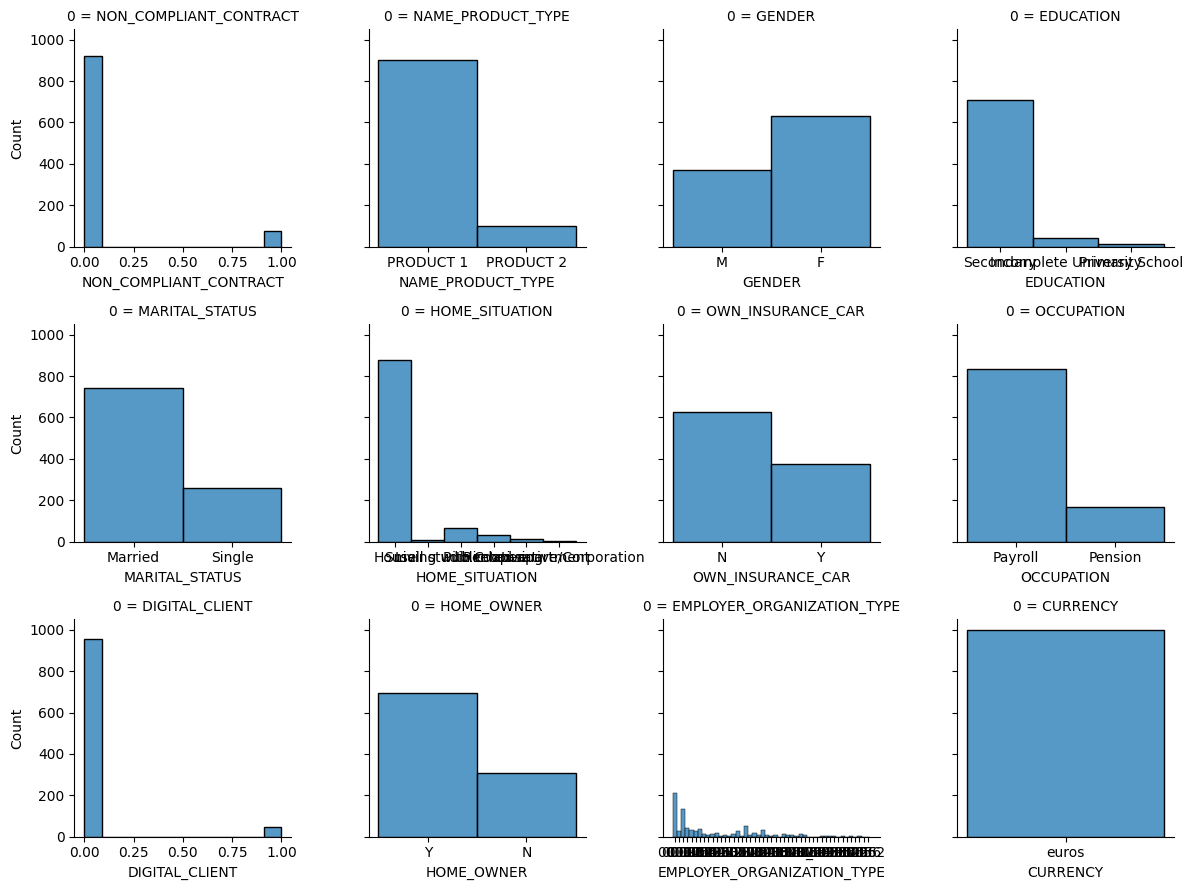

In [ ]:
# A quick visualization, with room for improvement
g = sns.FacetGrid(pd.DataFrame(features_categorical), col=0, col_wrap=4, sharex=False)

for ax, xvar in zip(g.axes, features_categorical):
    sns.histplot(data=df_clients_sample, x=xvar, ax=ax)

g.tight_layout()

In [ ]:
# Count of each HOME_SITUATION and EMPLOYER_ORGANIZATION_TYPE category
print(df_clients["HOME_SITUATION"].value_counts(ascending=True))

df_clients["EMPLOYER_ORGANIZATION_TYPE"].value_counts(
    ascending=True
).head()  # Only the lowest 5

HOME_SITUATION
Cooperative/Corporation       590
Small studio                 1358
Rented apartment             2597
Public housing               5986
Living with relative         7867
House                      144579
Name: count, dtype: int64


EMPLOYER_ORGANIZATION_TYPE
0073    15
0072    28
0071    37
0070    37
0068    49
Name: count, dtype: int64

Notice that:

- There is a near 90% imbalance in our target variable, with negatives as the majority class.

- In fact, most categorical variables have imbalance, for example:
    
    - PRODUCT_1 is the most frequent product type.
    
    - ~30/70 in GENDER (demographic features are potential sources of bias, and should be handled with care).

- EMPLOYER_ORGANIZATION_TYPE with many categories, some with few values.

- CURRENCY is always the same in our data and thus does not provide any information.

Takeaways:

- CURRENCY can be removed **for this analysis**, but any model that uses money-related data should take the currency into account. Some options could be transforming the values to a common currency using the closest FX for the observation, or training models for each currency/geography. The value of money changes over time, something relevant when the data is not recorded in a short time-frame.

- EMPLOYER_ORGANIZATION_TYPE should be considered for merging into bigger groups or other types of segmentations, as there is not enough information in some of them. For simplicity I will not use the variable, but a proper analysis would check for correlation of each category with the target variable, and maybe select some categories.

- Idem for HOME_SITUATION.

In [26]:
df_clients[features_numerical].describe()

,TOTAL_INCOME,AMOUNT_PRODUCT,INSTALLMENT,REGION_SCORE,AGE_IN_YEARS,JOB_SENIORITY,HOME_SENIORITY,LAST_UPDATE,CAR_AGE,FAMILY_SIZE,...,LOAN_CREDIT_GRANTED_MAX,LOAN_CREDIT_GRANTED_MIN,LOAN_CREDIT_GRANTED_SUM,LOAN_VARIABLE_RATE_MAX,LOAN_VARIABLE_RATE_MIN,NUM_STATUS_ANNULLED,NUM_STATUS_AUTHORIZED,NUM_STATUS_DENIED,NUM_STATUS_NOT_USED,NUM_FLAG_INSURED
count,1.629770e+05,162977.000000,162970.000000,162977.000000,162977.000000,133803.000000,162977.000000,162977.000000,55427.000000,162975.000000,...,154207.000000,154207.000000,154207.000000,154207.000000,154207.000000,154207.000000,154207.000000,154207.000000,154207.000000,154207.000000
mean,2.029339e+03,7193.391443,325.583354,0.020516,43.951931,2398.921459,4987.488180,2992.176141,11.987407,2.152441,...,4976.108054,589.061184,11430.967524,0.120342,0.018078,0.889165,3.040786,0.843700,0.077279,0.968627
std,3.722499e+03,4831.534717,173.477501,0.012600,11.931164,2360.495553,3520.915689,1510.215965,11.799483,0.909643,...,5495.291012,1179.925808,17705.720635,0.130622,0.058542,1.676969,2.125891,1.811074,0.325360,1.316550
min,3.078000e+02,540.000000,19.390000,0.000533,20.517808,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000015,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.350000e+03,3240.000000,198.880000,0.010006,34.073973,770.000000,2011.000000,1714.000000,5.000000,2.000000,...,1256.690000,0.000000,1885.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.782000e+03,6162.370000,299.160000,0.018850,43.200000,1650.000000,4508.000000,3254.000000,9.000000,2.000000,...,2700.000000,286.200000,5157.920000,0.103979,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000
75%,2.430000e+03,9703.800000,415.787500,0.028663,53.884932,3194.000000,7483.000000,4297.000000,15.000000,3.000000,...,6611.380000,709.070000,13879.995000,0.178872,0.000000,1.000000,4.000000,1.000000,0.000000,1.000000
max,1.404000e+06,48486.195000,2898.155000,0.059364,69.082192,17729.000000,24044.000000,6874.000000,64.500000,18.000000,...,51684.235000,45445.320000,445896.035000,0.976633,0.867498,51.500000,25.500000,57.500000,12.000000,16.500000


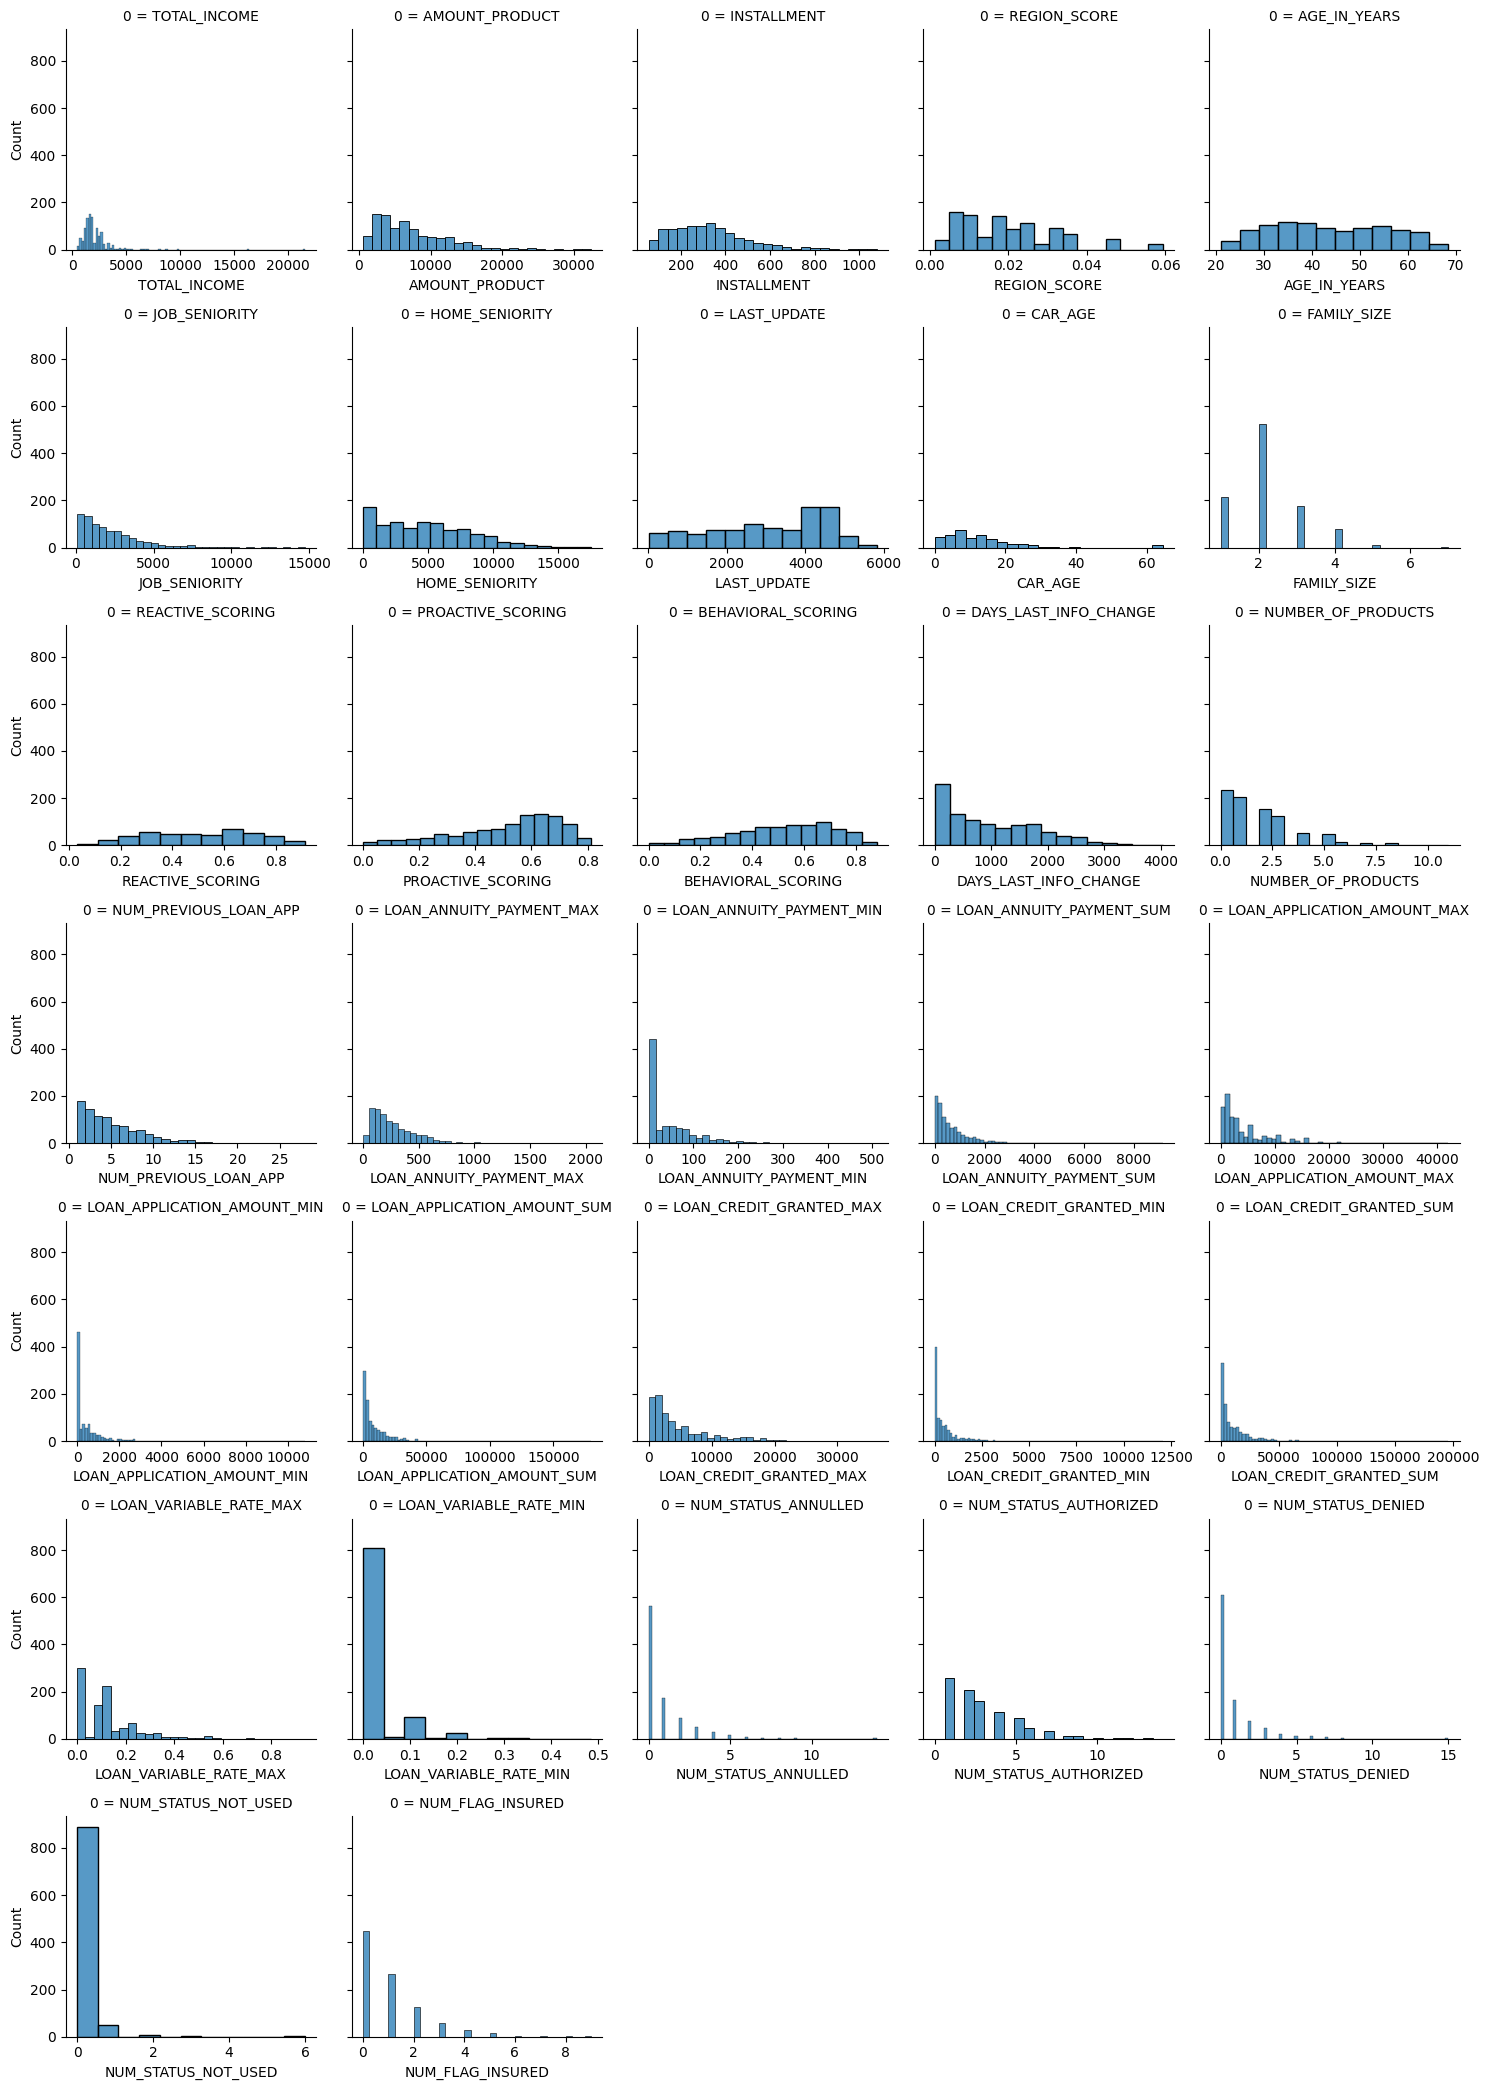

In [28]:
# A quick visualization that could be improved
g = sns.FacetGrid(pd.DataFrame(features_numerical), col=0, col_wrap=5, sharex=False)

for ax, xvar in zip(g.axes, features_numerical):
    sns.histplot(data=df_clients_sample, x=xvar, ax=ax)

g.tight_layout()

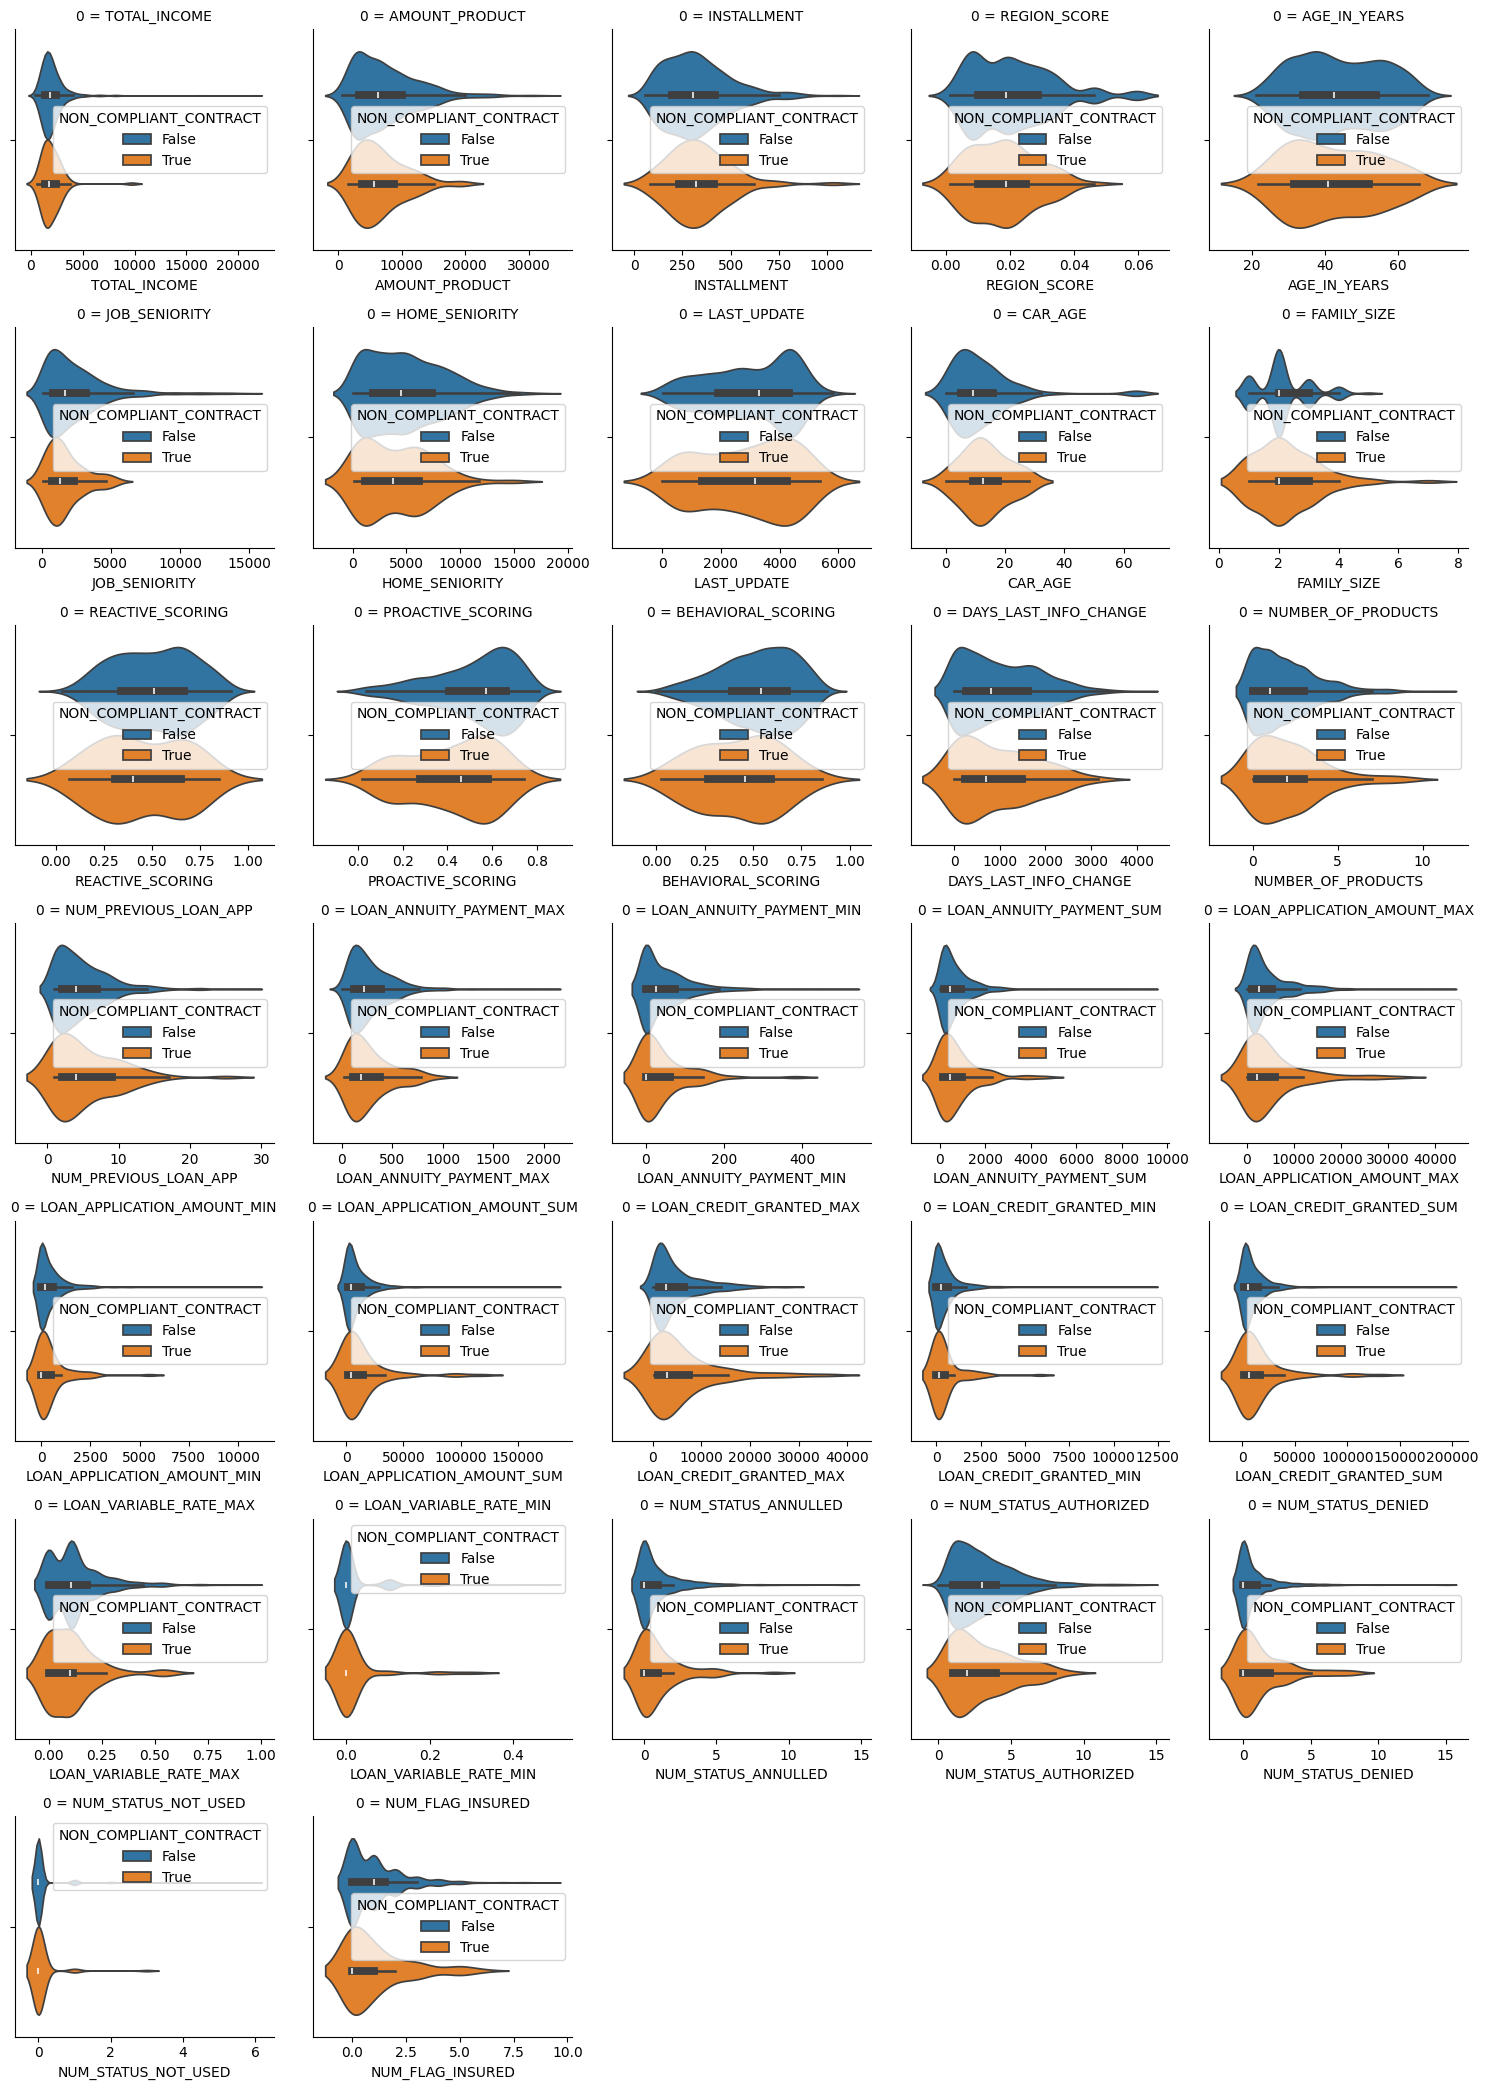

In [30]:
# A quick visualization that could be improved
g = sns.FacetGrid(pd.DataFrame(features_numerical), col=0, col_wrap=5, sharex=False)

for ax, xvar in zip(g.axes, features_numerical):
    sns.violinplot(data=df_clients_sample, x=xvar, ax=ax, hue=target)

g.tight_layout()

Normally I would dedicate a good part of my time to visualize the data with pairplots, density plots, Q-Q plots and the like. Histograms can give different messages depending on the number of bins selected, so I do not favour them.

Nevertheless, with the ones above we can learn some things:

- Variables do not follow a normal distribution.
- Some have long tails, and thus, outliers.
- There is a high concentration near zero (probably missing data).
- The distributions does not change with our target variable.

Before continuing with the data analyses below we should have encoded the categorical variables into numerical. For simplicity I do not, and focus on the numerical ones.

## Anomalies

Some models are very sensitive to outliers. At first, it is important to understand if the anomalies represent real values or errors in the data extraction process.
It is also worth remembering that outliers are not limited to a one or two dimensional space, as the combination of values in multiple variables could also be unusual (think of a very young person, student, and with lots of years in their current job, something possible but not frequent).

We can think of this as a distance based problem. How we define what is normal and what metric to measure it is what gives us the distinction.

How to treat anomalies should depend of the problem at hand. We should consider whether they belong to the same distribution the rest of the data come from, and if so, how much do we want to influence our model. We could remove them entirely, or segment the data and use different models in each group. Note that the normalization is also affected by outliers.

For this dataset, we could assume that the data has come from a quality system and is curated. For example, credit card data is unlikely to contain natural errors.
However, other data (like demographic variables) could come directly from the client, and thus in some cases be ill defined.

I will use a KNN method to identify anomalies in the dataset and remove them. Other methods that could be tested:

- Isolation Forest
- ECOD from the [pyod](https://github.com/yzhao062/pyod) library
- Models that can use observation-level weights

Some references to look at:

- [Deep Learning for Anomaly Detection: A Review](https://dl.acm.org/doi/abs/10.1145/3439950)
- [Best-Practice Recommendations for Defining, Identifying, and Handling Outliers](https://journals.sagepub.com/doi/abs/10.1177/1094428112470848)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Preprocessing pipeline
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# By default non-specified columns are dropped
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_numerical),
        ("cat", categorical_transformer, features_categorical),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

x = pipe.fit_transform(df_clients)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)

is_outlier = lof.fit_predict(x)

# We could set a threshold for how much is enough to consider an outlier as so
# outlier_score = lof.negative_outlier_factor_

In [ ]:
# Add "outlier" flag to DF
df_clients["outlier"] = (is_outlier == -1) # Outliers -> Those with -1
df_clients[df_clients["outlier"]][target].value_counts()

NON_COMPLIANT_CONTRACT
False    13893
True      2405
Name: count, dtype: int64

Around a 1% is detected as anomaly, and there are outliers in both categories of our target variable

## Correlation

Correlation with the target variable could be beneficial, but correlation (not only the linear kind) between the predictor variables can negatively affect some models. For example, linear models solutions can be numerically unstable.

Some references:

- [Multicollinearity and misleading statistical results](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6900425/)
- [Multicollinearity in Regression Analyses Conducted in Epidemiologic Studies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4888898/)
- [Correlation](https://en.wikipedia.org/wiki/Correlation)
- [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)

 Therefore, is good to identify which variables are correlated in our dataset. I will plot the Pearson correlation coefficient for each pair of features

<Axes: >

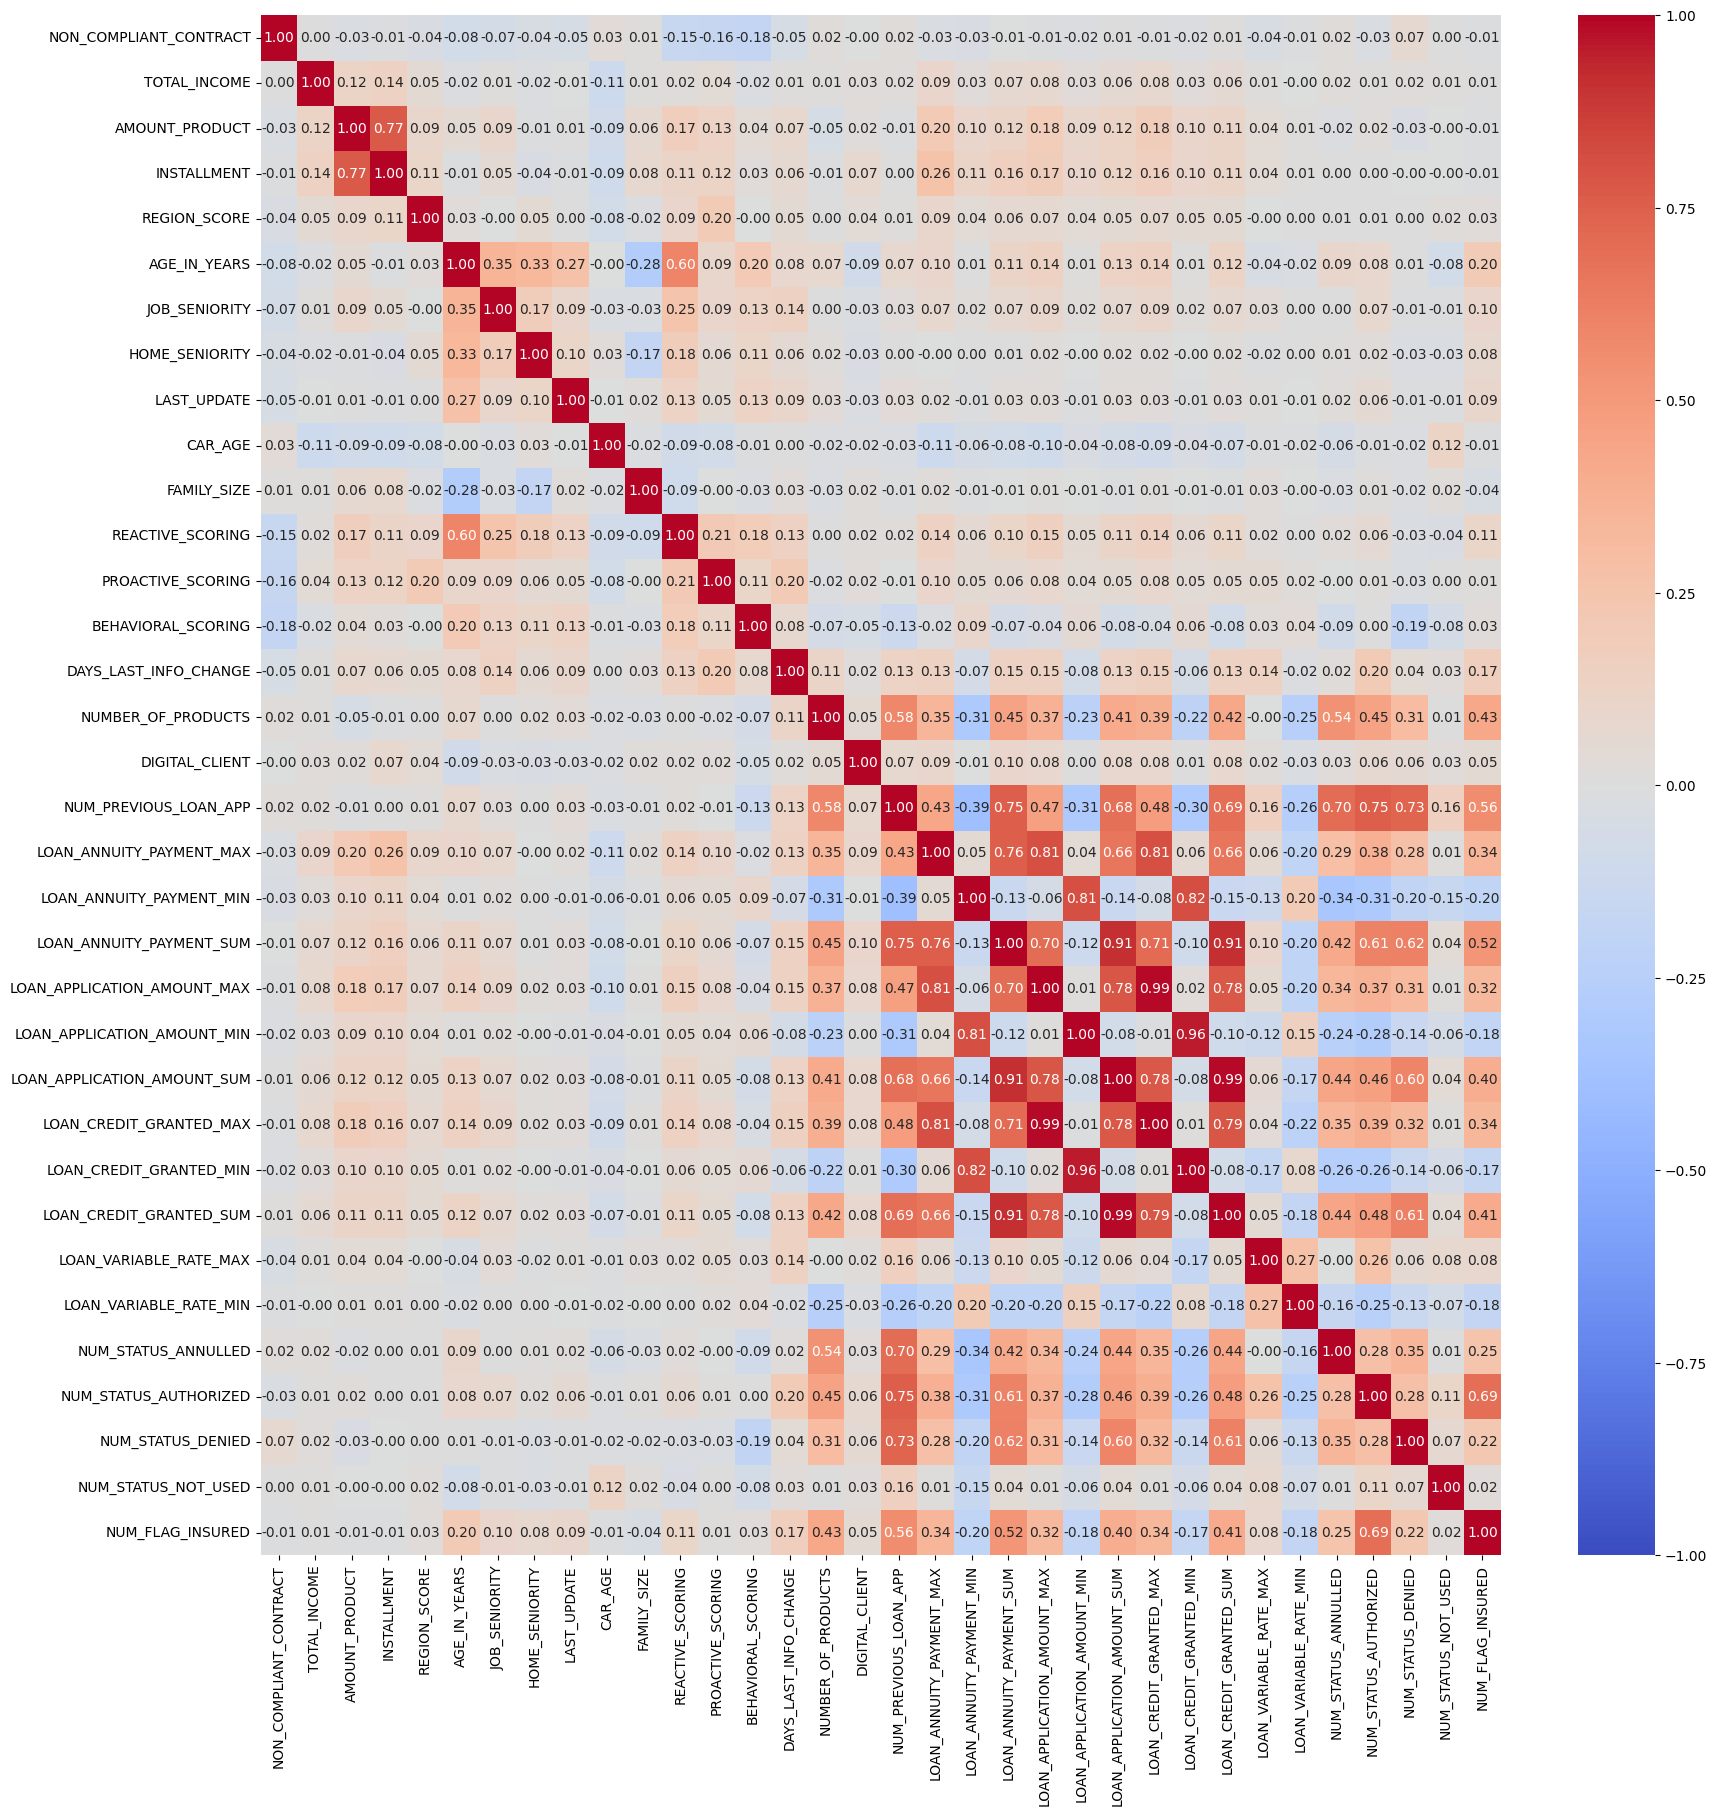

In [ ]:
# Plotting linear correlation
# (only of numerical variables, categorical should be transformed before)

plt.figure(figsize=(20, 20))
sns.heatmap(
    df_clients[features_numerical].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1.0,
    vmax=1.0,
)

In general, variables are mostly linearly uncorrelated, specially with the target variable. Only those that are the same measures of something (LOAN_ANNUITY SUM/MAX/MIN, LOAN_APPLICATION_AMOUNT, LOAN_CREDIT_GRANTED...) are correlated between them.

## Missing data

It is also important to known if some observations has missing features. If left unprocessed, some models would assume a value of zero and our results would be biased.

In [34]:
missing_vals = df_clients.isnull().mean()
missing_vals.sort_values(ascending=False).head(15)

CAR_AGE                        0.659909
REACTIVE_SCORING               0.563889
EDUCATION                      0.243225
BEHAVIORAL_SCORING             0.197856
EMPLOYER_ORGANIZATION_TYPE     0.180786
JOB_SENIORITY                  0.179007
NUMBER_OF_PRODUCTS             0.134393
NUM_FLAG_INSURED               0.053811
LOAN_ANNUITY_PAYMENT_MIN       0.053811
NUM_PREVIOUS_LOAN_APP          0.053811
LOAN_ANNUITY_PAYMENT_SUM       0.053811
LOAN_APPLICATION_AMOUNT_MAX    0.053811
LOAN_APPLICATION_AMOUNT_MIN    0.053811
LOAN_APPLICATION_AMOUNT_SUM    0.053811
LOAN_CREDIT_GRANTED_MAX        0.053811
dtype: float64

Note that we lack lots of values for some variables. Like with anomalies, we should try to identify why this is happening (e.g. a missing CAR_AGE means that the client does not have a car, or that it was bought for less than a year ago?).

## Data augmentation

I won't extract any new feature given that we already have quite a few variables in the CLIENTS dataset. Nevertheless, for some questions (like the salary estimation one) I believe that from the BEHAVIOURAL CREDIT_CARD_BALANCE something useful could be inferred. I will mention some approaches I can think of in `Question 3`.

# Question 1

**Can you design a code that detects those clients who are not going to fulfill the contractual conditions?**

Could be one of the most valuable for the success of the project. Identifying whose clients fulfil the requirements could help the marketing experts to design the best approach for the products. It also opens the door for some interesting analyses:

- What client segments are more likely to fulfil the contract?
- What is our target market? How big it is?
- What makes a client valid? Could some other product be defined for those who not?

Note that:

1. The question is asking for those who **do NOT** fulfil the contractual conditions, therefore, we are interested in correctly predicting the majority class.
2. We should always look if a solution for a problem already has been tested (either in industry or academia), analyse it and build upon it.

## Preprocessing

**How should the data be prepared in order to extract more and better information about our customers? Which treatments and methodologies do you propose? What new variables may you create to know more about the client?**

---

I will apply the following techniques:

- Feature selection
- Normalization
- Missing values imputation
- Treatment of class imbalance

Some references to look at:
- [cleanlab](https://github.com/cleanlab/cleanlab)

As mentioned before, outliers can negatively influence the models, so I will remove them

In [ ]:
# Remove outliers
df_clients = df_clients[~df_clients["outlier"]]

### Feature selection

Having too many variables with not enough data implies a high-dimensional space with low density data (a.k.a. curse of dimensionality), so it is important to select the best features for training. We have several options:

- Remove the variables.
- Combine them, for example, with PCA to keep the maximum variability, or encode them into a low-dimensional space with a neural network.
- Some models can also apply feature selection (e.g. CART, Lasso penalty in Logistic Regression).

For this problem, given that we already have many variables and for simplicity's sake, at the cost of losing valuable information I will delete them according to different criteria. I have also tested to automatically remove those variables with low variance, but it worsens the results, probably because the data is concentrated and even low thresholds remove lots of features.

**Note**: Without specific knowledge about the product DAYS_LAST_INFO_CHANGE (and others) may or may not be relevant for prediction.
We will assume that complying with the contract conditions is not related with the number of days from the last email update.

In [ ]:
features_to_remove = [
    # Target variable
    "NON_COMPLIANT_CONTRACT",

    # Categorical with low or no variance
    "CURRENCY",
    "EMPLOYER_ORGANIZATION_TYPE",
    "HOME_SITUATION",

    # Could be unrelated with target (correlation vs causation)
    "DAYS_LAST_INFO_CHANGE",

    # Possible not be related with the target variable (should be analysed)
    "LAST_UPDATE",

    # For a new client we don't have this information
    "NAME_PRODUCT_TYPE",
    "AMOUNT_PRODUCTS",
]

features_to_remove.extend(
    df_clients.columns[missing_vals > 0.15] # High missing values (>15%)

    # These are:
    # "CAR_AGE",
    # "REACTIVE_SCORING",
    # "EDUCATION",
    # "BEHAVIORAL_SCORING",
    # "EMPLOYER_ORGANIZATION_TYPE",
    # "JOB_SENIORITY",
    # "NUMBER_OF_PRODUCTS",
)

features_to_remove.extend(
    remove_collinear_features(df_clients[features_numerical], 0.7)
)

In [ ]:
# Update our list of features
features_categorical = features_categorical.drop(
    features_to_remove, errors="ignore"
)
features_numerical = features_numerical.drop(
    features_to_remove, errors="ignore"
)

print("Features to use:")
print("Categorical: ", features_categorical)
print("Numerical: ", features_numerical)

Features to use:
Categorical:  Index(['GENDER', 'MARITAL_STATUS', 'OWN_INSURANCE_CAR', 'OCCUPATION',
       'DIGITAL_CLIENT', 'HOME_OWNER'],
      dtype='object')
Numerical:  Index(['TOTAL_INCOME', 'AMOUNT_PRODUCT', 'REGION_SCORE', 'AGE_IN_YEARS',
       'HOME_SENIORITY', 'FAMILY_SIZE', 'PROACTIVE_SCORING',
       'NUMBER_OF_PRODUCTS', 'NUM_PREVIOUS_LOAN_APP',
       'LOAN_ANNUITY_PAYMENT_MAX', 'LOAN_ANNUITY_PAYMENT_MIN',
       'LOAN_VARIABLE_RATE_MAX', 'LOAN_VARIABLE_RATE_MIN',
       'NUM_STATUS_ANNULLED', 'NUM_STATUS_NOT_USED', 'NUM_FLAG_INSURED'],
      dtype='object')


### Normalization 

For normalization of numerical features, standard scaling is only suitable for normally distributed data. Although some models assume normality, changing the underlying distribution could not be appropriate. Even though no proper analysis has been done (Q-Q test, normality test), from the plots we can safely assume its not (still, keep in mind that distributions without missing data has not been plotted). Therefore, I will use a min-max scaler because it keeps the data distribution unchanged.

As for categorical variables, we will need to transform them to numeric. One-hot encoding could create too many dummy variables, ending up with a sparse dataset. Still, given that I removed those with lots of categories I will use it. In particular, I will create `k-1` dummy variables for binary features (assuming the variable represents all possible categories), and `k` dummy variables on the rest (assuming that some categories may be missing).

Additionally:

- There are no ordinal variables, otherwise they should be treated properly, as the order is relevant and the distances between each category unknown.
- There are numeric variables no continuous (age, counters). Those kind should be taken into account in the interpretation of the results (e.g. coefficients in logistic regression).

Regarding missing values imputation, what value to use should depend on the variable at hand (e.g. for NUMBER_OF_PRODUCTS we could assume 0 as default value, but not for AGE_IN_YEARS). In fact, it should be considered whether to use the variable or not, as for high percentage of missing values it may not make sense (remember we deleted some variables earlier).

I will use median because is simple, centred and not affected by outliers, but other methods could be tried. For example:

- Use expert knowledge to set a default value.
- Simpler statistical methods (mean, median, mode).
- If enough data, train a model to predict the value.

Some references to look at:
- [Evaluation of Multiple Imputation with Large Proportions of Missing Data: How Much Is Too Much?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8426774/)
- [Sklearn impute module](https://scikit-learn.org/stable/modules/impute.html)

Other scaling methods:
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Define preprocessing pipeline
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
    ]
) # k-1 dummy variables for binary features

# By default non-specified columns are dropped
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_numerical),
        ("cat", categorical_transformer, features_categorical),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

In [ ]:
x = pipe.fit_transform(df_clients)
y = df_clients[target] * 1.0 # Convert to float

(x.shape, y.shape)

((162977, 28), (162977,))

In [ ]:
remaining_columns = pipe.get_feature_names_out(pipe.feature_names_in_)
remaining_columns

array(['num__TOTAL_INCOME', 'num__AMOUNT_PRODUCT', 'num__REGION_SCORE',
       'num__AGE_IN_YEARS', 'num__HOME_SENIORITY', 'num__FAMILY_SIZE',
       'num__PROACTIVE_SCORING', 'num__NUMBER_OF_PRODUCTS',
       'num__NUM_PREVIOUS_LOAN_APP', 'num__LOAN_ANNUITY_PAYMENT_MAX',
       'num__LOAN_ANNUITY_PAYMENT_MIN', 'num__LOAN_VARIABLE_RATE_MAX',
       'num__LOAN_VARIABLE_RATE_MIN', 'num__NUM_STATUS_ANNULLED',
       'num__NUM_STATUS_NOT_USED', 'num__NUM_FLAG_INSURED',
       'cat__GENDER_M', 'cat__MARITAL_STATUS_Married',
       'cat__MARITAL_STATUS_Single', 'cat__MARITAL_STATUS_nan',
       'cat__OWN_INSURANCE_CAR_Y', 'cat__OCCUPATION_Maternity_leave',
       'cat__OCCUPATION_Payroll', 'cat__OCCUPATION_Pension',
       'cat__OCCUPATION_Students', 'cat__OCCUPATION_Unemploy',
       'cat__DIGITAL_CLIENT_True', 'cat__HOME_OWNER_Y'], dtype=object)

### Treatment of class imbalance

We have a strongly imbalanced dataset, so if we do not treat it properly the models will favour the majority class. We could:

- Downsample the majority class. However, if our observations are very distinct one from another we are losing useful information.
- Oversample the minority class, at the risk of simulating erroneous data.
- Not change the distribution of the dataset and use models that can take into account the imbalance. I will follow this procedure for simplicity. 

We could test different class_weights depending on our preferences. Although we are trying to maximize or 0-class, I will reverse the proportion so that the model does not try to predict always the same, ending with weights ``(0.08, 0.92)``.

We must also take into account that the random baseline in our case is higher (92% accuracy), that is, what we could achieve if we always says the client does not comply, and thus some metrics can be misleading.

Some references to look at:
- [Imbalance](https://sci2s.ugr.es/imbalanced)

### Train-test split

We could use cross-validation (CV) to minimize the information lost while creating a test sample. However, the metrics I display below would be optimistic given that they are calculated from the ``predict()`` function. In CV, that would mean predicting with the best model trained, and that model would have learned with data of the validation dataset. The proper method would be to compute each metric from the average of all models used in CV, and this would have taken quite some time.

In fact, CV is more suitable to decide between hyperparameters/configuration/preprocessing, not for the final training of a model.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED
)

## Model training

It is always good practice to start with a simple (strong bias, low variance) model like a linear model or a decision tree and then, if needed (and available under the requirements of the problem), move to complex models. When choosing the models we should also consider the model assumptions. For example, Logistic Regression assumes absence of multicollinearity.

I will compare a linear with an ensemble model. For linear, I select a Logistic Regression model, but to apply regularization (given the number of variables I kept) I include Lasso that reduces the coefficients to zero (i.e. feature selection). However, because Lasso have difficulties with highly-correlated data, I use ElasticNet instead, that combines Lasso with Ridge.

As for hyperparameters, they should be tuned with a grid-search cross-validation process or other methods (random or bayesian sampling).

In [ ]:
from sklearn.linear_model import LogisticRegression

hyperparameters = {
    "penalty": "elasticnet",
    "solver": "saga",  # Only for elasticnet
    "l1_ratio": 0.5,  # Only for elasticnet
    "C": 1.0,  # Default value
    
    "class_weight": (
        1 - (y_train.value_counts() / y_train.size)
    ).to_dict(),  # -1 to make them inversely proportional to class frequencies
}

model_lr = LogisticRegression(random_state=SEED, **hyperparameters)
model_lr.fit(x_train, y_train)

LogisticRegression(class_weight={0.0: 0.08185241714667013,
                                 1.0: 0.9181475828533299},
                   l1_ratio=0.5, penalty='elasticnet', random_state=12345,
                   solver='saga')

In [ ]:
# Look at the coefficients
pd.Series(model_lr.coef_[0], index=remaining_columns).sort_values(ascending=False)

num__NUM_PREVIOUS_LOAN_APP         2.716436
cat__OCCUPATION_Unemploy           0.726918
cat__GENDER_M                      0.476087
num__LOAN_VARIABLE_RATE_MIN        0.432919
cat__MARITAL_STATUS_Single         0.106561
num__NUMBER_OF_PRODUCTS            0.039603
num__FAMILY_SIZE                   0.000575
num__TOTAL_INCOME                  0.000000
cat__OCCUPATION_Students           0.000000
cat__OCCUPATION_Payroll            0.000000
cat__OCCUPATION_Maternity_leave    0.000000
cat__MARITAL_STATUS_nan            0.000000
cat__MARITAL_STATUS_Married        0.000000
cat__HOME_OWNER_Y                 -0.006207
cat__DIGITAL_CLIENT_True          -0.059319
num__AMOUNT_PRODUCT               -0.089483
num__REGION_SCORE                 -0.190715
num__NUM_STATUS_ANNULLED          -0.191573
cat__OCCUPATION_Pension           -0.194901
num__NUM_STATUS_NOT_USED          -0.240486
cat__OWN_INSURANCE_CAR_Y          -0.287897
num__HOME_SENIORITY               -0.426511
num__NUM_FLAG_INSURED           

Some notes:
- Disadvantageous to be unemployed
- Possible bias for Males
- The regularization has removed some features

For the ensemble model, I choose a Gradient Boosting based on LightGBM. This estimator has native support for missing values, but I will keep the median imputed values I created earlier.

We could have also used the [H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html) implementation

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Hyperparameters
# They should be tuned with grid-search or other methods
hyperparameters = {
    "learning_rate": 0.1,
    "max_iter": 500, # Max number of trees
    "early_stopping": True,
    "l2_regularization": 0.5,
    
    "class_weight": (
        1 - (y_train.value_counts() / y_train.size)
    ).to_dict(),  # -1 to make them inversely proportional to class frequencies
    # "class_weight": {0.0: 0.14, 1.0: 0.86}
}

model_gb = HistGradientBoostingClassifier(random_state=SEED, **hyperparameters)
model_gb.fit(x_train, y_train)

HistGradientBoostingClassifier(class_weight={0.0: 0.08185241714667013,
                                             1.0: 0.9181475828533299},
                               early_stopping=True, l2_regularization=0.5,
                               max_iter=500, random_state=12345)

Number of iterations: 63
Training score: -0.5932744438819098


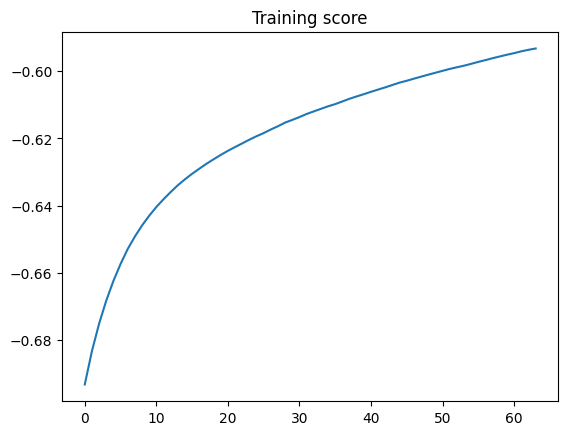

In [ ]:
# Print training stats
# n_iter = n_trees in gradient boosting
print(f"Number of iterations: {model_gb.n_iter_}")
print(f"Training score: {model_gb.train_score_[-1]}")

# Plot loss curve
plt.plot(model_gb.train_score_)
plt.title("Training score")
plt.show()

## Model evaluation

**Our PO is worried about the costs of offering our product to a customer that does not fulfill the contractual conditions. Which is the best metric to measure the quality of the results? What do you recommend?**

---

**If we assume a balanced dataset**, because this is a classification problem the model fit could be measured with the standard metrics (precision, recall, F-scores...).
We could display a ROC curve to see the behaviour of the model at different thresholds. If we are not willing to take risk in offering the product to non-valid-customers the threshold could be increased.

**However**, we have an imbalanced dataset, so a global view of the results is misleading. Instead, we should be looking at metric at each class level. I will put emphasis on the precision-recall curve, as it clearly compares the model with the baseline.

Some references to look at:
- [The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/)
- [The Relationship Between Precision-Recall and ROC Curves](https://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)

As a side note, when measuring the quality of the solution for a problem, we should seek a metric that does not depend on the model. For example, we could try to assign a number to the product (cost, return, benefit, churn) and use it as a penalty for a misclassification (could be one for FP (lost-of-opportunity) and one for FN (cost-of-contract)).

In addition, in our dataset the variable LAST_UPDATE could also give (or take) confidence in our prediction. Maybe the observation represents a customer that is not real anymore. This could also help us to identify data drift (e.g. if some profiles have not the same behaviour as another).

### Logistic Regression

               precision    recall  f1-score   support

non-compliant       0.95      0.66      0.78     30032
    compliant       0.13      0.61      0.22      2564

     accuracy                           0.66     32596
    macro avg       0.54      0.63      0.50     32596
 weighted avg       0.89      0.66      0.74     32596



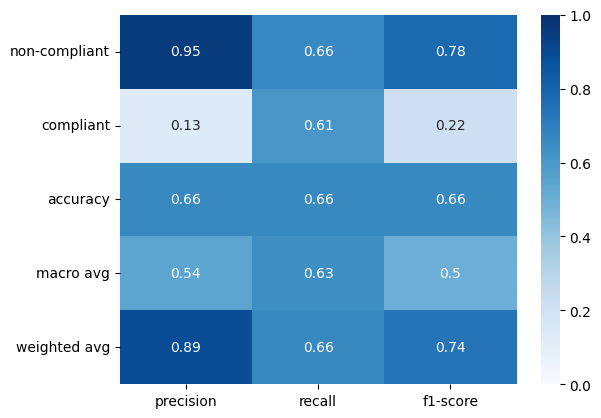

In [ ]:
y_pred_lr = model_lr.predict(x_test)
target_names = ["non-compliant", "compliant"]

get_classification_report(y_test, y_pred_lr, target_names=target_names)

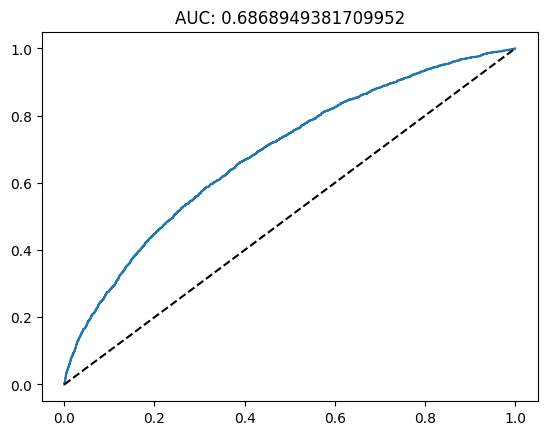

In [ ]:
y_pred_proba_lr = model_lr.predict_proba(x_test)[::,1]

auc_curve(y_test, y_pred_proba_lr)

The confusion matrix can be deceiving as it does not clearly reflects the data imbalance

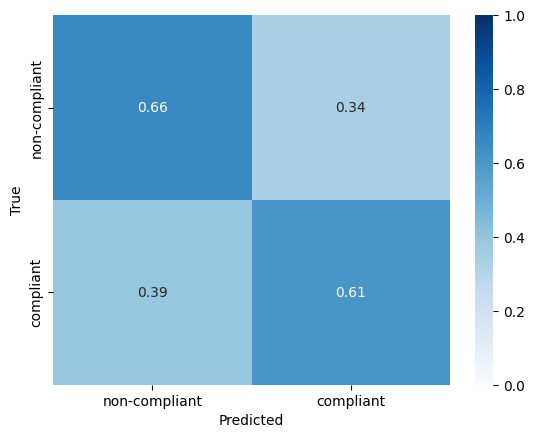

In [ ]:
plot_confusion_matrix(y_test, y_pred_lr, target_names)

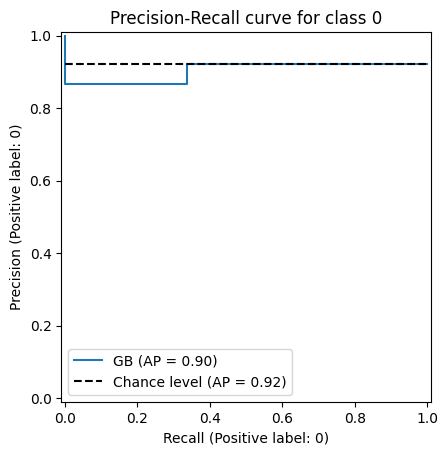

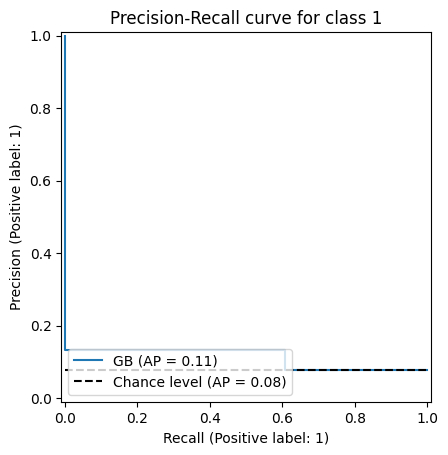

In [ ]:
plot_precision_recall(y_test, y_pred_lr, 0)
plot_precision_recall(y_test, y_pred_lr, 1)

### Gradient Boosting

               precision    recall  f1-score   support

non-compliant       0.95      0.67      0.79     30032
    compliant       0.14      0.61      0.22      2564

     accuracy                           0.66     32596
    macro avg       0.54      0.64      0.50     32596
 weighted avg       0.89      0.66      0.74     32596



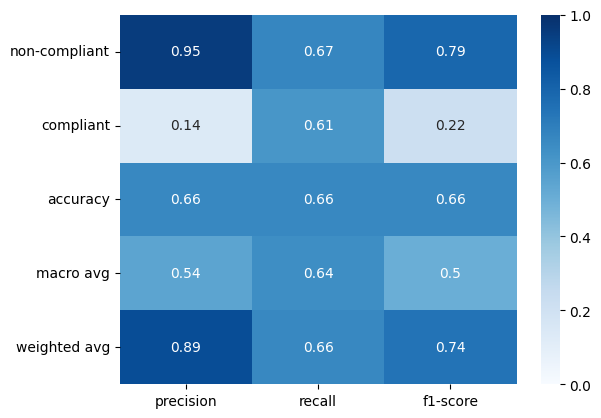

In [ ]:
y_pred_gb = model_gb.predict(x_test)
target_names = ["non-compliant", "compliant"]

get_classification_report(y_test, y_pred_gb, target_names=target_names)

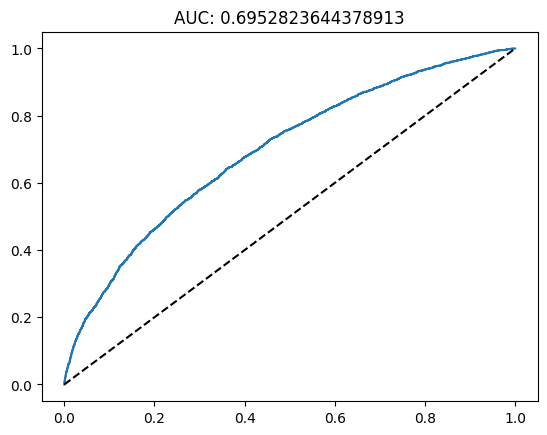

In [ ]:
y_pred_proba_gb = model_gb.predict_proba(x_test)[::,1]

auc_curve(y_test, y_pred_proba_gb) # In our case 0.5 is not the random baseline

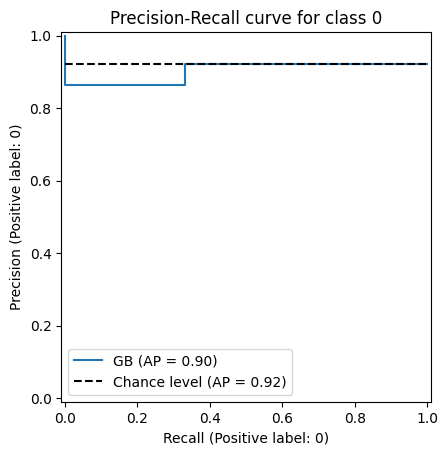

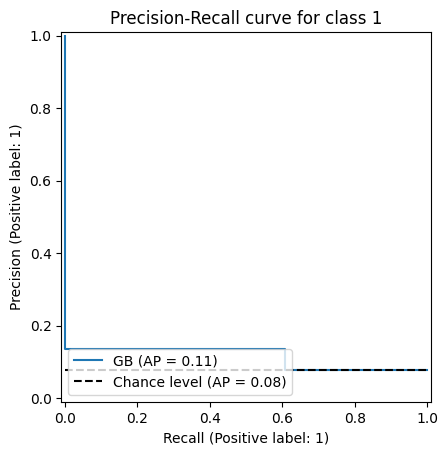

In [ ]:
plot_precision_recall(y_test, y_pred_gb, 0)
plot_precision_recall(y_test, y_pred_gb, 1)

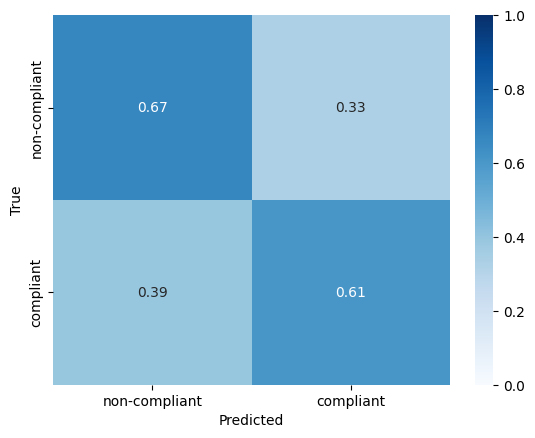

In [ ]:
plot_confusion_matrix(y_test, y_pred_gb, target_names)

Out of curiosity, I display the results changing slightly the weights

               precision    recall  f1-score   support

non-compliant       0.94      0.89      0.91     30032
    compliant       0.20      0.32      0.24      2564

     accuracy                           0.84     32596
    macro avg       0.57      0.60      0.58     32596
 weighted avg       0.88      0.84      0.86     32596



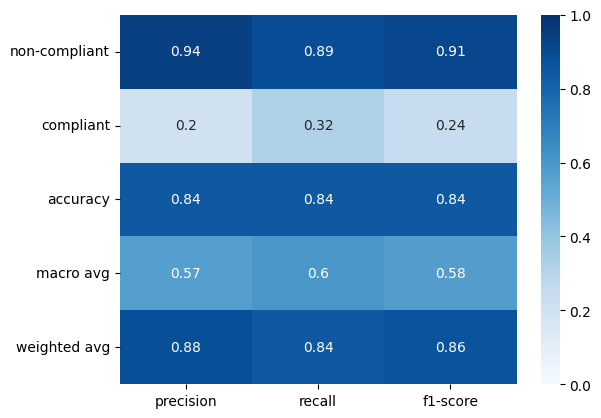

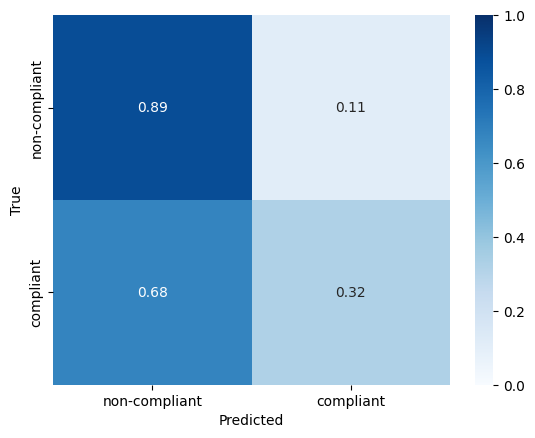

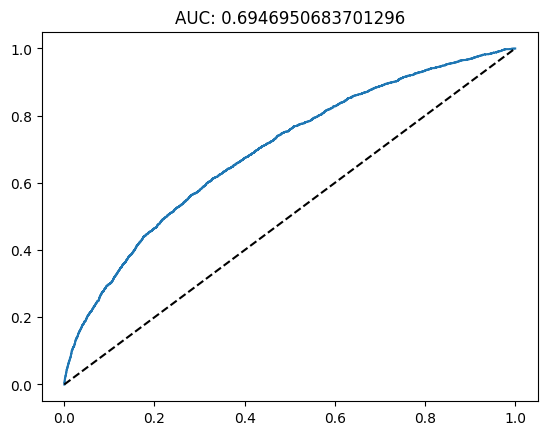

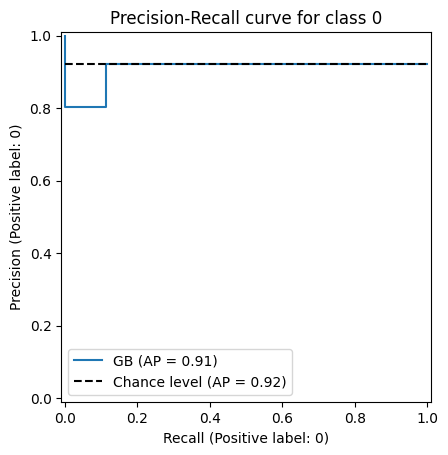

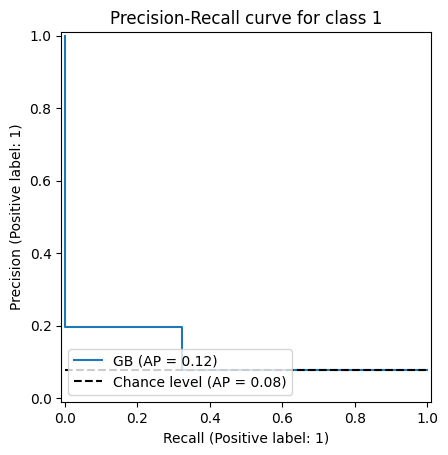

In [ ]:
# Testing weights: 0.14-0.86

hyperparameters["class_weight"] = {
    0.0: 0.14,
    1.0: 0.86,
}  # Class 0 previous weight duplicated

# Train
model = HistGradientBoostingClassifier(random_state=SEED, **hyperparameters)
model.fit(x_train, y_train)

# Estimate
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[::, 1]

# Plot metrics
get_classification_report(y_test, y_pred, target_names=target_names)
plot_confusion_matrix(y_test, y_pred, target_names)
auc_curve(y_test, y_pred_proba)
plot_precision_recall(y_test, y_pred, 0)
plot_precision_recall(y_test, y_pred, 1)

## Conclusions

- Results are not good, although we somehow improve the baseline in the minority class, for the majority class (the target of the question) results are worse than the baseline.
- Whether a result is good enough should be decided according to a business analysis. The impact a misclassification has, the cost of a full-scale development and deployment, opportunity cost (are there other alternatives), and so on. Nevertheless, it is clear that there is still room for improvement on this experiment and other approaches (better preprocessing, tuning, data analysis, model-selection) could be conducted.
- There is almost no difference between both models, and that would worry me in a real-world situation. Either something is wrong with the data (and could possible be, because the preprocessing done is clearly not enough) and/or the code, or the models cannot extract more information (which seems unlikely).

**How can you prove that any model that you develop is not capturing noise? If you were auditing your own model from an outsider perspective, how would you determine whether or not the model is robust?**

---

To see if it is robust, when training the model I will look for:

- The metrics displayed above: Good F1-scores (classification) or MSE/MAE (regression), Precision/recall over the desired thresholds.
- Check if the model is generalizing.
- How outliers affect the model.
- Sensitivity analysis, counterfactuals: How the model is affected by small perturbations in the data.
- How are the predictions distributed? Is there any bias?
- If time is a variable, are the estimates (or the errors) stationary? Should they be?

**Once the model is in production, from an outsider perspective**:

- Model Foundations:
    - Is the model suited for the problem?
    - Comparing with alternative models (simpler vs complex)
    - Are model assumptions fulfilled?
- Data
    - Are the variables well suited for the problem
    - Is correctly normalized?
    - Is there any segmentation?
- Performance
    - Backtesting: see how the same model behaves through time. Has been data or concept drift?
    - Biases:
        - What features affect the overall behaviour of the model
        - What features affect random single predictions
        - What features affect different data segments (different age ranges, employment statuses)
    - Analysis of errors: Is there any cluster in them?
    - Counterfactuals
- IT infrastructure:
    - Is well defined?
    - Dependencies are wrote down?
    - Is documented?
    - The training environment is isolated (VM) or relies on other systems? Are these dependencies managed?

Some tools:

- [interpretml](https://github.com/interpretml/interpret/)
- [Responsible AI Toolbox](https://github.com/microsoft/responsible-ai-toolbox)
- [DiCE](https://github.com/interpretml/DiCE)
- [causalml](https://github.com/uber/causalml)
- [AIX360](https://github.com/Trusted-AI/AIX360)

# Question 2

**Currently the products are offered only to customers whose salaries are paid into a BBVA account. Our business partners are considering extending the product offering to more clients, even if they haven’t set up a direct salary deposit with us. Indeed, we think that it is viable to create a salary estimator for customers for whom we do not have **demographic** and **financial** data. Is this possible?**

The other most important question. Accurately estimating the salary would increase the number of potential customers and thus help guarantee the continuity of the product.

In this case, we will be lacking many variables from the dataset, so the BEHAVIOURAL dataset could be useful for this problem. For time restrictions I won't try it, but we could match those clients with credit card data and try to make an estimate from the balance/drawings.

Additionally, this a task prone to bias. AI directly impacting customers should be responsible and the prediction of salary is prone to the biases that exists in the society of today. We should think if we want to represent the data as it is or fix any possible bias in it.

In [54]:
# Features available

# Select variables
df_no_salary = df_clients[[
    "TOTAL_INCOME", # target

    # Scoring
    "REACTIVE_SCORING",
    "PROACTIVE_SCORING",
    "BEHAVIORAL_SCORING",
    
    # Debt
    "INSTALLMENT",
    "NUM_PREVIOUS_LOAN_APP",
    "LOAN_ANNUITY_PAYMENT_MAX",
    "LOAN_ANNUITY_PAYMENT_MIN",
    "LOAN_ANNUITY_PAYMENT_SUM",
    "LOAN_APPLICATION_AMOUNT_MAX",
    "LOAN_APPLICATION_AMOUNT_MIN",
    "LOAN_APPLICATION_AMOUNT_SUM",
    "LOAN_CREDIT_GRANTED_MAX",
    "LOAN_CREDIT_GRANTED_MIN",
    "LOAN_CREDIT_GRANTED_SUM",
    "LOAN_VARIABLE_RATE_MAX",
    "LOAN_VARIABLE_RATE_MIN",
    "NUM_STATUS_ANNULLED",
    "NUM_STATUS_AUTHORIZED",
    "NUM_STATUS_DENIED",
    "NUM_STATUS_NOT_USED",
    "NUM_FLAG_INSURED",
]]

df_no_salary.head(5)

,TOTAL_INCOME,REACTIVE_SCORING,PROACTIVE_SCORING,BEHAVIORAL_SCORING,INSTALLMENT,NUM_PREVIOUS_LOAN_APP,LOAN_ANNUITY_PAYMENT_MAX,LOAN_ANNUITY_PAYMENT_MIN,LOAN_ANNUITY_PAYMENT_SUM,LOAN_APPLICATION_AMOUNT_MAX,...,LOAN_CREDIT_GRANTED_MAX,LOAN_CREDIT_GRANTED_MIN,LOAN_CREDIT_GRANTED_SUM,LOAN_VARIABLE_RATE_MAX,LOAN_VARIABLE_RATE_MIN,NUM_STATUS_ANNULLED,NUM_STATUS_AUTHORIZED,NUM_STATUS_DENIED,NUM_STATUS_NOT_USED,NUM_FLAG_INSURED
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
ES182411319L,1350.0,0.182429,0.563161,0.538863,276.75,5.0,156.41,62.92,467.66,2160.00,...,2445.12,316.82,4248.18,0.592495,0.0,0.0,5.0,0.0,0.0,3.0
ES182116369S,918.0,NaN,0.519744,0.686382,261.31,2.0,90.25,0.00,90.25,809.95,...,895.48,0.00,895.48,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
ES182154395P,1350.0,NaN,0.264443,0.524496,298.24,3.0,132.49,27.00,256.53,772.20,...,731.70,352.84,1624.54,0.108909,0.0,0.0,3.0,0.0,0.0,1.0
ES182369450D,1620.0,0.607521,0.699410,0.698668,386.37,2.0,110.44,42.11,152.56,1090.80,...,1205.98,899.05,2105.03,0.000000,0.0,0.0,2.0,0.0,0.0,1.0
ES182116792X,2430.0,NaN,0.314247,0.231439,242.30,1.0,108.00,108.00,108.00,0.00,...,2160.00,2160.00,2160.00,0.000000,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
# Identify different columns types
target = "TOTAL_INCOME"
features_categorical = df_no_salary.select_dtypes(exclude="number").columns
features_numerical = df_no_salary.select_dtypes(include="number").columns.drop(target)

## Data Analysis

I will take a look again at this subset, specially at the new target variable

In [27]:
# Plot statistics at varios percentiles
round(df_no_salary[target].describe(percentiles=np.arange(0.1, 1.0, 0.1)))

count     162977.0
mean        2029.0
std         3722.0
min          308.0
10%          972.0
20%         1188.0
30%         1350.0
40%         1620.0
50%         1782.0
60%         1944.0
70%         2160.0
80%         2700.0
90%         3240.0
max      1404000.0
Name: TOTAL_INCOME, dtype: float64

Worth noting that although the description says annual income figures, because the currency is in euros they are most likely **monthly** income figures (although it could be data from another country changed to euros)

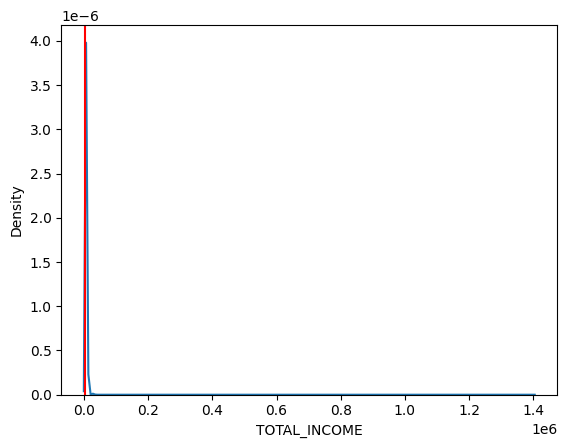

In [28]:
# Plot distribution
sns.kdeplot(df_no_salary, x=target)

# Add percentile 95 line to the kdeplot
plt.axvline(df_no_salary[target].quantile(0.95), color="red")
plt.show()

We have strong outliers. As mentioned above they should be analysed as in this case they are probably real (representing wealthy people) and we still may want the model to be able to predict them. One possible option would be training a model specifically for them, for example, segmenting into monetary classes, or separating the body of the distribution from the tail.

However, for simplicity I will remove them

In [29]:
# Choosing .95 given the plot, but we could try to idenfy the body of the distr
df_no_salary = df_no_salary[df_no_salary[target] < df_no_salary[target].quantile(0.95)]

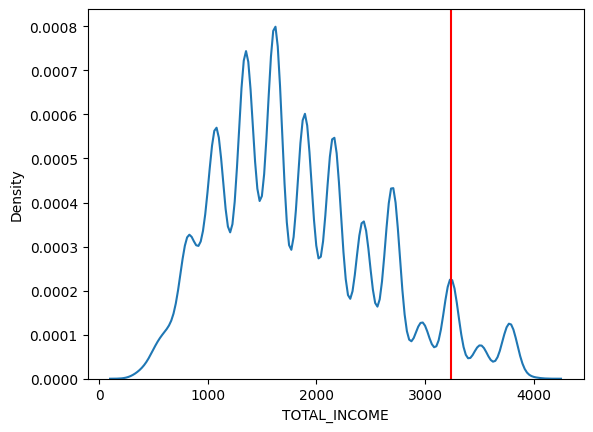

In [31]:
# Plot distribution
sns.kdeplot(df_no_salary, x=target)

# Add percentile 95 line to the kdeplot
plt.axvline(df_no_salary[target].quantile(0.95), color="red")
plt.show()

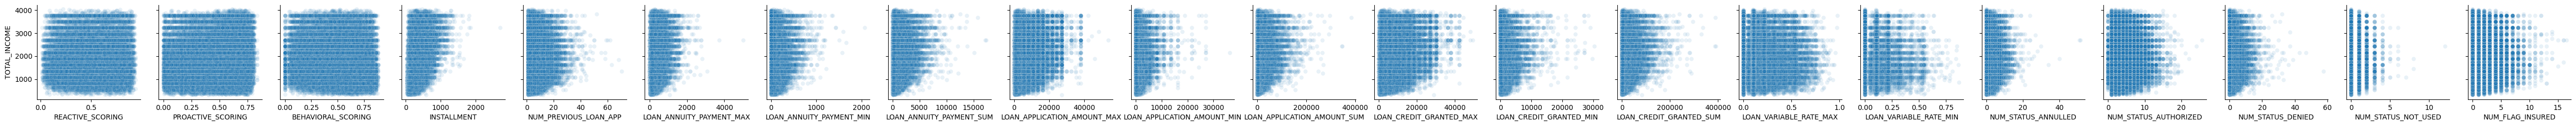

In [32]:
# Pair plot each variable against target
sns.pairplot(
    df_no_salary, x_vars=features_numerical, y_vars=target, plot_kws={"alpha": 0.1}
)

Looks like there is no apparent correlation the target, but there is high concentration of values near zero and strong outliers

## Preprocessing

Again, we will remove variables with a high percentage of missing values and scale it to the [0-1] range.
Because there are no categorical variables, no encoding is needed

In [38]:
# Define features to remove
features_to_remove = [
    # Target variable
    target, # "TOTAL_INCOME",
]
features_to_remove.extend(
    df_clients.columns[missing_vals > 0.15] # High missing values (>15%)

    # "REACTIVE_SCORING",
    # "BEHAVIORAL_SCORING",
    # "NUMBER_OF_PRODUCTS",
)
features_to_remove.extend(
    remove_collinear_features(df_no_salary[features_numerical], 0.7)
)

# Drop features
features_categorical = features_categorical.drop(features_to_remove, errors="ignore")
features_numerical = features_numerical.drop(features_to_remove, errors="ignore")

print("Features to use")
print("Categorical: ", features_categorical)
print("Numerical: ", features_numerical)

Features to use
Categorical:  Index([], dtype='object')
Numerical:  Index(['PROACTIVE_SCORING', 'INSTALLMENT', 'NUM_PREVIOUS_LOAN_APP',
       'LOAN_ANNUITY_PAYMENT_MAX', 'LOAN_ANNUITY_PAYMENT_MIN',
       'LOAN_VARIABLE_RATE_MAX', 'LOAN_VARIABLE_RATE_MIN',
       'NUM_STATUS_ANNULLED', 'NUM_STATUS_NOT_USED', 'NUM_FLAG_INSURED'],
      dtype='object')


In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ]
)

# By default non-specified columns are dropped
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_numerical),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

In [40]:
y = df_no_salary[target].to_numpy()
x = pipe.fit_transform(df_no_salary)

print("Shape of predictors ", x.shape)

# Get remaining columns
print("Remaining columns:")
remaining_columns = pipe.get_feature_names_out(pipe.feature_names_in_)
remaining_columns

Shape of predictors  (154641, 10)
Remaining columns:


array(['num__PROACTIVE_SCORING', 'num__INSTALLMENT',
       'num__NUM_PREVIOUS_LOAN_APP', 'num__LOAN_ANNUITY_PAYMENT_MAX',
       'num__LOAN_ANNUITY_PAYMENT_MIN', 'num__LOAN_VARIABLE_RATE_MAX',
       'num__LOAN_VARIABLE_RATE_MIN', 'num__NUM_STATUS_ANNULLED',
       'num__NUM_STATUS_NOT_USED', 'num__NUM_FLAG_INSURED'], dtype=object)

As a sanity-check, I plot a variable before and after the scaling to make sure that min-max worked and the distribution is unchanged.

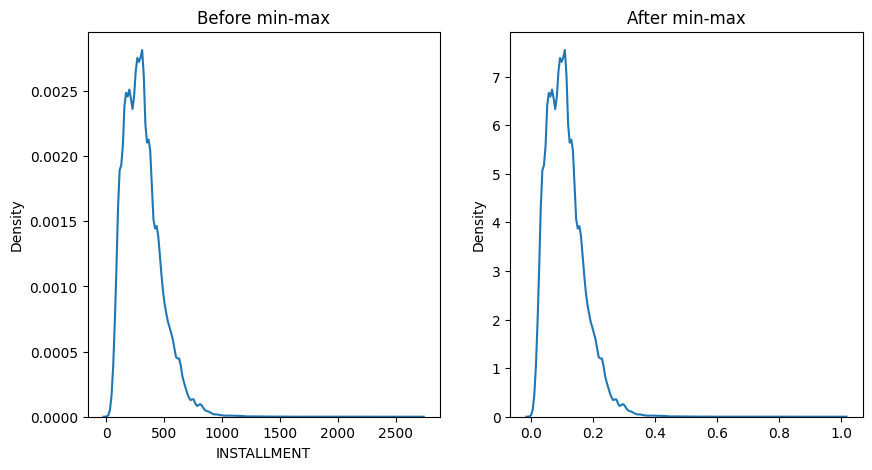

In [43]:
# To check min-max is working as expected
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot original values
sns.kdeplot(df_no_salary["INSTALLMENT"], ax=axes[0])
axes[0].set_title("Before min-max")

# Plot scaled values
sns.kdeplot(x[:, 1], ax=axes[1])
axes[1].set_title("After min-max")

plt.show()

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED
)

## Model training

As mentioned above, starting with a simple would be more appropriate, but to not use another linear model I will go this time with a Random Forest. Hyperparameters should be selected with cross-validation, but for time considerations I will keep the default values.

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters should be chosen with CV, keeping default values
hyperparameters = {
    "n_estimators": 100,
    # "max_depth": None,
    "min_samples_leaf": 1,
    "oob_score": True # To see the performance of the model
}

# Define the SVR model
model = RandomForestRegressor(random_state=SEED, **hyperparameters)
model.fit(x_train, y_train)

RandomForestRegressor(oob_score=True, random_state=12345)

In [50]:
# See feature importance
pd.Series(model.feature_importances_, index=remaining_columns).sort_values(
    ascending=False
)

num__INSTALLMENT                 0.342055
num__LOAN_ANNUITY_PAYMENT_MAX    0.186466
num__PROACTIVE_SCORING           0.175166
num__LOAN_VARIABLE_RATE_MAX      0.088673
num__LOAN_ANNUITY_PAYMENT_MIN    0.076263
num__NUM_PREVIOUS_LOAN_APP       0.049579
num__NUM_FLAG_INSURED            0.030934
num__NUM_STATUS_ANNULLED         0.024820
num__LOAN_VARIABLE_RATE_MIN      0.018136
num__NUM_STATUS_NOT_USED         0.007909
dtype: float64

Looking at the coefficients seems reasonable that the current debt could be a potential predictor for the income. If the client has been granted high loans is probably because it has been estimated that is capable of paying them. Still, the client may default, so we should take this interpretation with a grain of salt.

In [52]:
y_pred = model.predict(x_test)

# Compare variances
print(f"Std of true values:      {np.std(y_test)}")
print(f"Std of predicted values: {np.std(y_pred)}")

Std of true values:      753.6186044273937
Std of predicted values: 416.0183972638852


## Model evaluation

This is a regression problem, so we need to measure the quality with other metrics.

We could also extract confidence intervals for the predictions with the [quantile-forest](https://github.com/zillow/quantile-forest) package.

In [53]:
# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print training stats
print(f"Out-of-bag R^2: {model.oob_score_}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Out-of-bag R^2: 0.20772739121811745
Mean Squared Error: 437725.3074391268
Mean Absolute Error: 525.8088211484368


The R^2 is low and making an average of 500€ error towards the total monthly income is high

<Axes: ylabel='Density'>

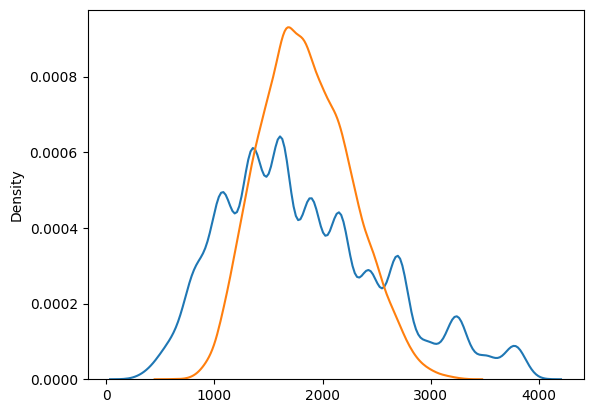

In [84]:
# Plot the distributions
sns.kdeplot(y_test)
sns.kdeplot(y_pred)

# Add legends
plt.legend(['True Values', 'Predicted Values'])

## Conclusions

- Again, there is still room for improvement
- We would still need to address those outliers removed

# Question 3

**Can you propose new data, procedures or methodologies to apply with the idea of giving continuity to our project (you can also consider other sources of data). Even the most cutting-edge and crazy ideas could be implemented in our innovation space. Therefore, do not limit yourself in terms of your ideas, papers or interesting things that you read.**

With the information provided about the project:

Data:
- Account balance / debit card balance through time
- Mortgage related data (not grouped under debt)
- Extract customer behaviour on the app/web (clicks, operations) to measure effects of marketing (e.g. which products)
- Likewise, identify patterns in customer's operations to ensure they qualify for the contract requirements

Models:
- Segmentation, looking to normality with variational autoencoders and/or adversarial networks.
- Reinforcement Learning from Human Feedback to improve client preferences.
- Ensemble and deep learning models for more complex but least interpretable models.
- Learning relationships between clients using transactional or other operational data with graph theory and graph neural networks.
- Analysis of the evolution of customer profiles over time and the impact of economic cycles or other country-level actions on them.

Although not fully applicable, some related papers:

- [How are reinforcement learning and deep learning algorithms used for big data based decision making in financial industries-A review and research agenda](https://www.sciencedirect.com/science/article/pii/S2667096822000374)
- [Supervised hashing with kernels](https://ieeexplore.ieee.org/abstract/document/6247912)

Nevertheless, we should be aware of the forthcoming EU AI act, as regulators are focusing on AI and will impose constraints on the models, enforce the companies to identify and manage the risks with the idea of protecting the customers. Thus, some things like explainability, anonymisation and lack of bias will be a must.

Some interesting tools:

- [River](https://github.com/online-ml/river) for continual learning, that could be applied over card/transaction data
- [vowpal_wabbit](https://github.com/VowpalWabbit/vowpal_wabbit) for RL
- [Faiss](https://github.com/facebookresearch/faiss) for similarity search
- [Snorkel](https://github.com/snorkel-team/snorkel) for simulating data (e.g. customer profiles)

# Brain-storming of other questions

I won't extensively answer the questions below, but I will write down some thoughts about them and some references to read when facing those kind of problems 

**As you can see in the description of the variables below, we have three scores (reactive, proactive and behavioral) provided by the risk department. These scores are useful, but are calculated only for those clients that meet certain characteristics defined by the risk department. As you will notice, they are not defined for all the clients of the dataset. We want to develop an estimate for these clients based on the clients who own this value. Can you develop a simple (prediction) model to estimate these scores for those without this value? Please explain.**

---

A missing data imputation problem, where the scores become the target variables.

Two options:
- Simpler methods (filling based on statistics or default values with expert knowledge)
- If enough scored data, train a regression model for each score.

Some references to look at:
- [Evaluation of Multiple Imputation with Large Proportions of Missing Data: How Much Is Too Much?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8426774/)
- [Sklearn impute module](https://scikit-learn.org/stable/modules/impute.html)

**To which customers should each product be offered? Can you identify which customers are more likely to contract one of the two categories of products? Do you detect any interesting group of customers?**

---

To decide which product to offer, we could train a binary classification model with the compliant data, or multiclass with all the data (product1, product2, no_product). In the latter, the model would tend to first classify once again to no-compliant clients given the imbalance.

For segmentation, we could use unsupervised methods for clustering (KNN, KMeans, DBScan)

**We are concerned that our data may contain biases that could lead us to draw erroneous conclusions or exclude certain groups of clients. What analyses can you perform in order to to dispel our concerns?**

---

We could:

- Analyze the most import features for the model. Hopefully the variables we worry about are not there, and if they are, then no group is consistently punished (or rewarded)
- Segment the data and analyse both positives and negatives in each group

Some references to look at:

- [IBM AI Fairness 360 (AIF360)](https://github.com/Trusted-AI/AIF360)
- [Fairlearn](https://github.com/fairlearn/fairlearn)
- [Good practices for quantitative bias analysis](https://pubmed.ncbi.nlm.nih.gov/25080530/)

**Concerning the treatment of unusual values, which treatments have you used to solve this problem? Why?**

- **Can you think of other interesting techniques to solve the problem?**
- **Have you found any unusual data that you have preprocessed?**

---

Anomalies should be looked at not only in the 1D space but beyond. 

To treat them, we should consider whether they belong to the same distribution the rest of the data come from, and if so, how much do we want to influence or model. Note that the normalization is also affected by outliers.

For this dataset, we could assume that the data has come from a quality system and is curated. For example, credit card data is unlikely to contain natural errors.
However, other data (like demographic variables) could come directly from the client, and thus in some cases be ill defined. Still, I would say that the scores may be the variables most likely to have outliers, because it seems to proceed from another model.


Some references to look at:

- [Deep Learning for Anomaly Detection: A Review](https://dl.acm.org/doi/abs/10.1145/3439950)
- [Best-Practice Recommendations for Defining, Identifying, and Handling Outliers](https://journals.sagepub.com/doi/abs/10.1177/1094428112470848)

**It is true that economic factors along with varying consumer habits may influence data distribution. These factors can alter the underlying relationships between input and output data. As a result, the performance of a model will be degraded. How can you overcome this problem?**

---

I would even separate the effect in two parts: If the distribution changes trough time we are facing a data drift problem, but if for an unchanged input the real output changes then we are looking at a concept drift.

The former can be managed with a good monitoring of the model performance and the data distribution, re-training if necessary.
The latter, however, requires a more in-depth analysis of the problem and to question again the data selected.

And not only the economy, even a successful model may alter the data (e.g. good marketing may attract different type of customers).

Some references to look at:

- [Learning under Concept Drift: A Review](https://ieeexplore.ieee.org/abstract/document/8496795)
- [A survey on concept drift adaptation](https://dl.acm.org/doi/abs/10.1145/2523813)